# Comparaison de LOF, OC-SVM et Isolation Forest

## Jeux de données

Nous utilisons deux jeux de données Shuttle et KDD-Cup99 HTTP

## Algorithmes comparées

Nous comparons LOF, OC-SVM et Isolation Forest qui sont des méthodes non supervisées de détection d'anomalies
Pour chacune de ces méthodes, 
- Nous utilisons l'implémentation faite par sckit-learn
- Nous les initialisons avec les valeurs par défaut
- Pour chaque méthode, nous faisons varier un paramètre et exécutons la méthode sur le jeu de données un certain nombre (x) de fois.
- La moyenne des x temps d'exécution et de AUC donne la valeur à considérer pour cette valeur de paramètre concernant cette méthode.
    - Isolation Forest : Contamination (0 à 0,5 pas de 0,1) ----Plutôt faire varier n_estimators (50 à 300 pas de 10)----
    - OC-SVM           : nu (0,1 à 1 pas de 0,1) comme dans Goldein et Uchida
    - LOF              : n_neighbors (5 à 200 pas de 5) comme dans Goldein et Uchida
- Ceci permet de connaître pour chaque algorithme la valeur du paramètre le plus important qui permet d'avoir le meilleur résultat.
- La courbe ROC sera alors déssinée pour toutes les méthodes ensemble en utilisant leur meilleur paramètres.
- Un tableau sera fait pour comparer le temps d'exécution moyen, la précision moyenne, la AUC moyenne, le rappel moyen des méthodes sur chaque jeu de données.
- Les interprétations seront données pour chaque méthode à propos de chaque jeu de données et pour tous les jeux de données par la suite.

NB: On ne peut pas dessiner la courbe des AUCs comme dans Goldein et Uchida parce que les méthodes qu'ils ont comparé ont des paramètres en commun notamment les méthodes basées sur les plus proche voisins. Ce qui fait qu'ils ont pu tracer la courbe des AUCs en fansant varier le nombre de voinsins et comparer les performances des méthodes entre elle. Dans notre cas, ces trois méthodes n'ont rien en commun pour un tel exercice.
    

## Métriques de comparaison

Nous comparaons ces méthodes sur la base du temps d'éxécution et sur la base de l'air sous la courbe ROC (ROC AUC)
- Nous calculons le temps d'exécution de la fonction sur ces jeux de données avec la fonction time() que nous appelons avant de lancer l'initialisation de la méthode pour avoir l'heure de début.
    Nous appelons encore la fonction time() à la fin de l'exécution de la fonction predict() de la méthode pour avoir l'heure de fin du traitement.
    La différence entre ces deux moments nous donne le temps d'éxécution de la méthode en secondes (s)
- Nous calculons l'air sous la courbe ROC avec la fonction roc_auc_score() de scikit-learn
- La précision
- Le rappel
- Le score f1
- la courbe ROC
#### Temps d'exécution
    Le temps d'exécution est le temps qui sépare le lancement de la méthode à la fin de sa prédiction. Ceci permettra d'évaluer les différentes méthodes en fonction de temps qu'elles prennent pour classer les observations dans le dataset en anomalies ou normales. Il sera tenu compte du fait que le temps d'exécution peut être fonction du type du jeu de données de la taille du jeu de données et du nombre de dimension.
#### Précision ()
       TP/(TP + FP)
    Le taux d'observations classées positives (ici normale) par la méthode par rapport à toutes les observations réellement normales
#### Rappel (TPR)
       TP/(TP + FN)
    C'est le taux d'observations positives (ici normale) ayant été correctement détectées par la méthode.
#### Score f1
       TP/(TP + (FN + FP)/2))
       F1 est la moyenne harmonique de la précision et du rappel. F1 donne plus de poids aux faibles valeurs et est donc utile pour comparer deux méthodes de classification
#### Courbe ROC

O = Outlier = Négatif
N = Normal  = Positif
- ----------
     O | N
- ----------
O | VN | FP
- ----------
N | FN | VP
    
#### ROC AUC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib.mlab import frange
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve


## Chargement du jeu de données Shuttle

Shuttle contient 10 attributs dont le dernier est la classe à expliquer.
Il y a 46464 observations dont 878 anormales.
Avec le dernier attribut, nous avons les classes "o" pour les anomalies et "n" pour les observations normales.

In [2]:
data_brut_Shuttle = pd.read_csv('/Users/thesard/Doctorat/These2018/ISEP/Developpements/EspaceIntelliJ/LearningAllInPython/Learning_IHM_Features/datasets/imported_datasets/shuttle-unsupervised-ad_2019-06-14 17:33:02.493755.csv', header=None, index_col=None)
X_Shuttle = data_brut_Shuttle[[0, 1, 2, 3, 4, 5, 6, 7, 8]]
y_brut_Shuttle = data_brut_Shuttle[[9]]
data_brut_Shuttle.describe()

,0,1,2,3,4,5,6,7,8
count,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000
mean,44.775482,-0.712509,84.834108,0.279291,38.652763,2.289708,40.070334,46.180419,6.299888
std,8.753404,44.218007,8.731175,37.317203,15.902506,177.518356,10.969455,17.052467,15.005878
min,27.000000,-4475.000000,21.000000,-3939.000000,-188.000000,-12809.000000,-26.000000,-353.000000,-356.000000
25%,37.000000,0.000000,79.000000,0.000000,34.000000,-4.000000,34.000000,35.000000,0.000000
50%,43.000000,0.000000,83.000000,0.000000,42.000000,0.000000,39.000000,41.000000,2.000000
75%,49.000000,0.000000,87.000000,0.000000,46.000000,5.000000,43.000000,52.000000,2.000000
max,123.000000,1963.000000,149.000000,3830.000000,436.000000,15164.000000,105.000000,270.000000,266.000000


## Chargement du jeu de données KDD99-Cup HTTP

KDD99-Cup HTTP contient 30 attributs dont le dernier est la classe à expliquer.
Il y a 620098 observations dont 1052 anormales.
Avec le dernier attribut, nous avons les classes "o" pour les anomalies et "n" pour les observations normales.

In [3]:
data_brut_KDD99CUP = pd.read_csv('/Users/thesard/Doctorat/These2018/ISEP/Developpements/EspaceIntelliJ/LearningAllInPython/Learning_IHM_Features/datasets/imported_datasets/kdd99-unsupervised-ad_2019-06-24 16:08:29.815617.csv', header=None, index_col=None)
X_KDD99CUP = data_brut_KDD99CUP[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13 ,14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]
y_brut_KDD99CUP = data_brut_KDD99CUP[[29]]
data_brut_KDD99CUP.describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,620098.000000,620098.000000,6.200980e+05,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,...,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000
mean,0.627670,280.374673,4.099298e+03,0.005012,0.912428,0.000947,0.000318,0.000013,0.000010,0.005409,...,127.698101,244.485422,0.996744,0.000796,0.074723,0.031820,0.001920,0.001473,0.087651,0.086732
std,53.972528,1509.901935,2.369388e+04,0.098271,0.282671,0.045654,0.017821,0.003592,0.003111,0.073346,...,105.897233,40.458619,0.033137,0.009522,0.185812,0.050689,0.030694,0.028037,0.274777,0.268543
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,210.000000,4.580000e+02,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,22.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,240.000000,1.425000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,96.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,302.000000,3.731000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.000000,0.000000
max,41065.000000,54540.000000,1.173059e+07,21.000000,1.000000,21.000000,1.000000,1.000000,1.000000,1.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Transformation de la classe à expliquer

L'objectif ici est de remplacer les "o" par -1 et les "n" par 1 afin de faire les matrices de confusion avec la fonction dédiée de scikit-learn.

In [4]:
y_transform_Shuttle = y_brut_Shuttle
y_transform_Shuttle = np.where(y_transform_Shuttle=='o',-1,1)
#y_transform
y_transform_KDD99CUP = y_brut_KDD99CUP
y_transform_KDD99CUP = np.where(y_transform_KDD99CUP=='o',-1,1)
#y_transform_KDD99CUP

## Shuttle

### Exécution de Isolation Forest sur le jeux de données Shuttle en faisant varier n_estimators

In [5]:

max_samples = 'auto'

averages_executions_time_IF_Shuttle = []
averages_roc_auc_IF_Shuttle = []

for j in range(10, 300, 10):
    n_estimators = j
    executions_time_IF_Shuttle = []
    roc_auc_IF_Shuttle = []
    for i in range(5):
        start_IF_Shuttle = time()
        
        func_IF_Shuttle = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
        func_IF_Shuttle.fit(X_Shuttle)
        y_pred_IF_Shuttle = func_IF_Shuttle.predict(X_Shuttle)

        # Calcul du temps d'exécution
        exec_time_IF_Shuttle = time() - start_IF_Shuttle
        executions_time_IF_Shuttle.append(exec_time_IF_Shuttle)

        # Calcul de l'aire sous la courbe ROC
        auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_IF_Shuttle)
        roc_auc_IF_Shuttle.append(auc_IF_Shuttle)
        #print("ROC AUC for Isolation Forest applied on Shuttle")
        #print(roc_auc_IF_Shuttle)
    print("Execution time of IsolationForest applied on Shuttle (in second)")
    print(executions_time_IF_Shuttle)
    print("ROC AUC for Isolation Forest applied on Shuttle")
    print(roc_auc_IF_Shuttle)
    averages_executions_time_IF_Shuttle.append(statistics.mean(executions_time_IF_Shuttle))
    averages_roc_auc_IF_Shuttle.append(statistics.mean(roc_auc_IF_Shuttle))

/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[0.43103790283203125, 0.4355888366699219, 0.4150211811065674, 0.5610771179199219, 0.5112731456756592]
ROC AUC for Isolation Forest applied on Shuttle
[0.9529767611384505, 0.9499758248121375, 0.9563607127912728, 0.9531412853344756, 0.9505562691738773]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[1.1420910358428955, 0.9584560394287109, 0.7817699909210205, 0.859246015548706, 0.8621351718902588]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9540169987848446, 0.9505343326144072, 0.9551778875083238, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[1.2591259479522705, 1.173518180847168, 1.0966122150421143, 1.4128477573394775, 1.6369400024414062]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9499538882526675, 0.949373443890928, 0.9505453008941421, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[2.034435987472534, 1.726597785949707, 1.6513590812683105, 2.08528995513916, 1.5280189514160156]
ROC AUC for Isolation Forest applied on Shuttle
[0.9580801093170214, 0.9534365544231049, 0.9511257452558817, 0.9487929995291885, 0.9512463963329668]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[1.9374489784240723, 1.7611498832702637, 1.9203009605407715, 1.8109049797058105, 1.8666479587554932]
ROC AUC for Isolation Forest applied on Shuttle
[0.9580801093170214, 0.9528561100613655, 0.9522756656996257, 0.9517061896176212, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[2.131838321685791, 2.1302242279052734, 2.4573941230773926, 2.460753917694092, 2.288135051727295]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9511147769761468, 0.9476321108057093, 0.9528561100613655, 0.9505343326144072]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[2.5886881351470947, 2.6734941005706787, 2.682482957839966, 2.7809369564056396, 3.1526501178741455]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9522756656996257, 0.9522756656996257, 0.9487929995291885, 0.9476321108057093]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.6802477836608887, 2.9864070415496826, 3.107619047164917, 2.9581282138824463, 2.9837841987609863]
ROC AUC for Isolation Forest applied on Shuttle
[0.9499538882526675, 0.9516952213378863, 0.9511147769761468, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.375458240509033, 3.204303026199341, 3.1923539638519287, 3.2720258235931396, 3.199881076812744]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9569192205935423, 0.9551778875083238, 0.9505343326144072, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.7040088176727295, 3.809349775314331, 3.6794869899749756, 3.80515193939209, 4.868165016174316]
ROC AUC for Isolation Forest applied on Shuttle
[0.9505343326144072, 0.9516952213378863, 0.9516952213378863, 0.954597443146584, 0.9505343326144072]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.007195711135864, 5.387622356414795, 4.625060796737671, 4.832353830337524, 5.600948095321655]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9528670783411003, 0.9522756656996257, 0.9511147769761468, 0.9569192205935423]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.613799095153809, 4.643831014633179, 5.371103048324585, 4.4284749031066895, 4.740011215209961]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9511147769761468, 0.9528561100613655, 0.9499538882526675, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.429809093475342, 5.4301769733428955, 6.485217094421387, 5.199697971343994, 5.5244300365448]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9499648565324026, 0.9522756656996257, 0.9569192205935423, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.417048931121826, 5.985644102096558, 5.399899005889893, 5.4616498947143555, 5.768394947052002]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9505453008941421, 0.9528561100613655, 0.9511147769761468, 0.949373443890928]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.145005226135254, 5.693637132644653, 5.306113004684448, 5.2800257205963135, 5.891430139541626]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9511147769761468, 0.9499538882526675, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.699141025543213, 7.057630777359009, 9.505704164505005, 6.221740961074829, 7.797239065170288]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9511147769761468, 0.9516952213378863, 0.9540169987848446, 0.949373443890928]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.288877248764038, 6.260418891906738, 6.222504138946533, 6.704073905944824, 6.96709680557251]
ROC AUC for Isolation Forest applied on Shuttle
[0.9499538882526675, 0.9522756656996257, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.480480194091797, 7.084450006484985, 6.619936943054199, 6.802766799926758, 6.442012071609497]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9534365544231049, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.146161794662476, 7.275901794433594, 7.184439182281494, 7.0973358154296875, 6.747941970825195]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9511147769761468, 0.9499538882526675, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.219103097915649, 8.352814197540283, 7.578938007354736, 7.480122804641724, 7.699251413345337]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.977267026901245, 7.974909067153931, 7.7598557472229, 7.896172046661377, 8.195299863815308]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9505343326144072, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.203197717666626, 9.351696252822876, 8.598716020584106, 10.346078872680664, 9.384166955947876]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9534365544231049, 0.9505343326144072, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[11.22852087020874, 11.436401128768921, 11.66942572593689, 13.157791137695312, 10.030635118484497]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.954597443146584, 0.9534365544231049, 0.9522756656996257, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[12.493605136871338, 11.744182825088501, 12.41071891784668, 9.858978748321533, 10.652988910675049]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9534365544231049, 0.9511147769761468, 0.9540169987848446, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.929949045181274, 11.447458744049072, 10.070409774780273, 9.06134295463562, 9.069718837738037]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9534365544231049, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.331416845321655, 9.39087986946106, 9.20726990699768, 10.14323616027832, 9.273991107940674]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.798256874084473, 9.5221266746521, 9.86213207244873, 9.613476037979126, 9.662375211715698]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9505343326144072, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[10.641808986663818, 12.402535915374756, 11.571316957473755, 10.416658878326416, 9.831680059432983]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9522756656996257, 0.9516952213378863, 0.9516952213378863, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[10.692094802856445, 11.535588026046753, 19.43449091911316, 12.972423315048218, 14.10976791381836]
ROC AUC for Isolation Forest applied on Shuttle
[0.949373443890928, 0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9516952213378863]


### Résultat de Isolation Forest sur Shuttle

Execution time of IsolationForest applied on Shuttle (in second)
[0.4707996368408203, 0.9207396507263184, 1.3158088207244873, 1.8051403522491456, 1.8592905521392822, 2.2936691284179687, 2.775650453567505, 3.143237257003784, 3.2488044261932374, 3.9732325077056885, 5.290636157989502, 5.1594438552856445, 5.613866233825684, 5.806527376174927, 5.863242244720459, 7.456291198730469, 6.488594198226929, 6.885929203033447, 7.090356111526489, 7.666045904159546, 7.960700750350952, 9.376771163940429, 11.504554796218873, 11.43209490776062, 9.915775871276855, 9.469358777999878, 9.691673374176025, 10.972800159454346, 13.748872995376587]


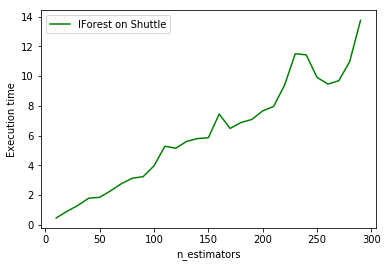

In [7]:
print("Execution time of IsolationForest applied on Shuttle (in second)")
print(averages_executions_time_IF_Shuttle)
plt.plot(range(10, 300, 10), averages_executions_time_IF_Shuttle,  "g-", label="IForest on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('n_estimators')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

ROC AUC for Isolation Forest applied on Shuttle
[0.9526021706500427, 0.953552643295453, 0.9514652372491375, 0.9525363609716326, 0.9536709258237478, 0.95076870401505, 0.9508825992314508, 0.9514630435931904, 0.9540169987848446, 0.9518113102102342, 0.9532087639903031, 0.9521595768272779, 0.9532065703343562, 0.9513491483767896, 0.9519273990825821, 0.9514630435931904, 0.9519273990825821, 0.9519273990825821, 0.9521595768272779, 0.9519273990825822, 0.9516952213378863, 0.9522756656996259, 0.9528561100613654, 0.9526239323166696, 0.9529721989337133, 0.9525078434443216, 0.9515791324655384, 0.9515791324655384, 0.9512308658484946]
La valeur max est 0.9540169987848446 à l'index 8


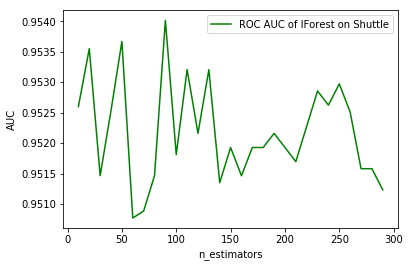

In [8]:
print("ROC AUC for Isolation Forest applied on Shuttle")
print(averages_roc_auc_IF_Shuttle)
print("La valeur max est "+str(max(averages_roc_auc_IF_Shuttle))+" à l'index "+str(averages_roc_auc_IF_Shuttle.index(max(averages_roc_auc_IF_Shuttle))))
plt.plot(range(10, 300, 10), averages_roc_auc_IF_Shuttle,  "g-", label="ROC AUC of IForest on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Exécution de Isolation Forest sur le jeux de données Shuttle en faisant varier max_samples

In [5]:

max_samples = 'auto'

averages_executions_time_IF_Shuttle = []
averages_roc_auc_IF_Shuttle = []

for j in range(100, len(X_Shuttle), 100):
    max_samples = j
    executions_time_IF_Shuttle = []
    roc_auc_IF_Shuttle = []
    for i in range(5):
        start_IF_Shuttle = time()
        
        func_IF_Shuttle = IsolationForest(max_samples=max_samples)
        func_IF_Shuttle.fit(X_Shuttle)
        y_pred_IF_Shuttle = func_IF_Shuttle.predict(X_Shuttle)

        # Calcul du temps d'exécution
        exec_time_IF_Shuttle = time() - start_IF_Shuttle
        executions_time_IF_Shuttle.append(exec_time_IF_Shuttle)

        # Calcul de l'aire sous la courbe ROC
        auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_IF_Shuttle)
        roc_auc_IF_Shuttle.append(auc_IF_Shuttle)
        #print("ROC AUC for Isolation Forest applied on Shuttle")
        #print(roc_auc_IF_Shuttle)
    print("Execution time of IsolationForest applied on Shuttle (in second)")
    print(executions_time_IF_Shuttle)
    print("ROC AUC for Isolation Forest applied on Shuttle")
    print(roc_auc_IF_Shuttle)
    averages_executions_time_IF_Shuttle.append(statistics.mean(executions_time_IF_Shuttle))
    averages_roc_auc_IF_Shuttle.append(statistics.mean(roc_auc_IF_Shuttle))

/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.191356897354126, 3.0212759971618652, 3.42480206489563, 3.7226619720458984, 4.378544092178345]
ROC AUC for Isolation Forest applied on Shuttle
[0.9487929995291885, 0.9487929995291885, 0.9476321108057093, 0.9482125551674488, 0.9487929995291885]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.291905164718628, 3.3072378635406494, 3.2773401737213135, 4.658457040786743, 4.078073978424072]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9511147769761468, 0.9505343326144072, 0.9528561100613655, 0.9499538882526675]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.517627716064453, 4.502696990966797, 3.711866855621338, 4.190847158432007, 4.437525987625122]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.954597443146584, 0.9551778875083238, 0.9487929995291885, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.301737070083618, 3.1620731353759766, 3.3190951347351074, 3.403571128845215, 3.3013248443603516]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9540169987848446, 0.9563387762318029, 0.9528561100613655, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.4346981048583984, 3.396077871322632, 3.403640031814575, 3.453742742538452, 3.516235113143921]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9574996649552819, 0.9563497445115378, 0.9574996649552819, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.269500255584717, 3.620023012161255, 3.8123650550842285, 3.505950927734375, 3.803757905960083]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9540169987848446, 0.9569192205935423, 0.9557583318700631, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.9891598224639893, 3.6721549034118652, 4.020142078399658, 3.5334577560424805, 3.6908700466156006]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9563387762318029, 0.958660553678761, 0.9563387762318029, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.577437162399292, 3.759087085723877, 3.7026288509368896, 3.453348159790039, 3.467740297317505]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9557693001497983, 0.9563387762318029, 0.9522756656996257, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.938145875930786, 3.592602014541626, 3.804643154144287, 3.439552068710327, 3.4891719818115234]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9551778875083238, 0.9580801093170214, 0.958660553678761, 0.9569301888732772]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.415760040283203, 3.4881107807159424, 4.179713010787964, 4.139667987823486, 4.162909984588623]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9563387762318029, 0.9569192205935423, 0.9580801093170214, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.258279800415039, 4.887712001800537, 4.395806074142456, 4.682211875915527, 5.269437074661255]
ROC AUC for Isolation Forest applied on Shuttle
[0.9574996649552819, 0.958660553678761, 0.954597443146584, 0.9563387762318029, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.355852127075195, 3.762460231781006, 3.6737630367279053, 3.740324020385742, 3.7497239112854004]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9563387762318029, 0.9563387762318029, 0.9569192205935423, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.200876951217651, 4.531267881393433, 4.660983085632324, 4.425206184387207, 4.185022830963135]
ROC AUC for Isolation Forest applied on Shuttle
[0.9574996649552819, 0.958660553678761, 0.9563387762318029, 0.957510633235017, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.8413331508636475, 3.8215792179107666, 3.767184257507324, 4.476852893829346, 4.525475978851318]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569301888732772, 0.958660553678761, 0.9569192205935423, 0.9563387762318029, 0.9580801093170214]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.021965026855469, 4.0086469650268555, 3.871774911880493, 3.848217010498047, 3.861248016357422]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9574996649552819, 0.958660553678761, 0.9574996649552819, 0.9580801093170214]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.8828351497650146, 3.8447201251983643, 3.904294013977051, 3.9178929328918457, 3.9354748725891113]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9563387762318029, 0.9563387762318029, 0.9563387762318029, 0.958660553678761]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.225378036499023, 3.9831080436706543, 3.9375951290130615, 3.8581790924072266, 3.867215156555176]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9563387762318029, 0.9557583318700631, 0.9551778875083238, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.742002248764038, 3.7297558784484863, 3.732529878616333, 3.7108852863311768, 3.8110039234161377]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9557583318700631, 0.9569192205935423, 0.9569192205935423, 0.9569192205935423]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.755141019821167, 4.267197132110596, 4.703334808349609, 4.205974102020264, 3.7100448608398438]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9574996649552819, 0.957510633235017, 0.958660553678761, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.7737958431243896, 3.6848251819610596, 3.658151149749756, 3.6624209880828857, 3.6469812393188477]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9569192205935423, 0.9528561100613655, 0.9563387762318029, 0.9569192205935423]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.9449779987335205, 3.976369857788086, 3.9603419303894043, 4.454745054244995, 3.943197727203369]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9569192205935423, 0.9569192205935423, 0.9580910775967564, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.9451510906219482, 3.99711275100708, 4.01582407951355, 3.9222028255462646, 3.883847236633301]
ROC AUC for Isolation Forest applied on Shuttle
[0.9580801093170214, 0.9569192205935423, 0.9569192205935423, 0.958660553678761, 0.9569192205935423]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.972074031829834, 3.949953079223633, 3.9969561100006104, 3.9311606884002686, 3.934161901473999]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9563387762318029, 0.9563387762318029, 0.9540169987848446, 0.9569192205935423]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.933264970779419, 3.9803860187530518, 3.8767809867858887, 3.871199131011963, 3.90212082862854]
ROC AUC for Isolation Forest applied on Shuttle
[0.9574996649552819, 0.9540169987848446, 0.9563387762318029, 0.9563387762318029, 0.9569192205935423]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.150552034378052, 4.291000127792358, 3.911130905151367, 3.9013538360595703, 4.030745983123779]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9557583318700631, 0.9574996649552819, 0.9563387762318029, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.9282102584838867, 3.8578529357910156, 3.9022159576416016, 3.875404119491577, 3.8918538093566895]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9580801093170214, 0.9557583318700631, 0.9569192205935423, 0.9574996649552819]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.9072608947753906, 3.9310572147369385, 3.9529848098754883, 3.8775370121002197, 3.912390947341919]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9563387762318029, 0.9540169987848446, 0.9569192205935423, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.89054012298584, 3.930311918258667, 3.9629859924316406, 3.9004597663879395, 3.893911123275757]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9569192205935423, 0.9551778875083238, 0.9551778875083238, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.295267105102539, 3.8758208751678467, 4.040041923522949, 4.03983211517334, 3.954232931137085]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.954597443146584, 0.9534365544231049, 0.9563387762318029, 0.9569192205935423]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.005141019821167, 3.9410972595214844, 3.9545297622680664, 3.857922077178955, 3.967834234237671]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9557583318700631, 0.9557583318700631, 0.9569192205935423, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.9747982025146484, 4.207296133041382, 4.55889892578125, 4.271620035171509, 5.007630825042725]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.954608411426319, 0.9528561100613655, 0.9551778875083238, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.349613904953003, 4.237829208374023, 5.075235843658447, 5.2820611000061035, 4.61956000328064]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9540169987848446, 0.9563497445115378, 0.9580801093170214, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.339015960693359, 4.297370910644531, 4.265887022018433, 4.138870000839233, 4.207334280014038]
ROC AUC for Isolation Forest applied on Shuttle
[0.9574996649552819, 0.9557583318700631, 0.9557583318700631, 0.9574996649552819, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.161714315414429, 3.9941070079803467, 3.985264778137207, 4.2178308963775635, 4.153711795806885]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9563387762318029, 0.9563387762318029, 0.954597443146584, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.098918914794922, 4.043912172317505, 4.263789653778076, 4.262359857559204, 4.068296909332275]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9551778875083238, 0.9563387762318029, 0.9569192205935423, 0.9563497445115378]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.010103225708008, 4.063582897186279, 4.415894031524658, 4.241983890533447, 4.279377222061157]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9557583318700631, 0.9551778875083238, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.8847591876983643, 3.94231915473938, 3.959599018096924, 3.9523630142211914, 4.743088960647583]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9551778875083238, 0.9574996649552819, 0.9563387762318029, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.01743483543396, 3.977637767791748, 3.965550184249878, 4.4193809032440186, 4.2286059856414795]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9563387762318029, 0.9563387762318029, 0.9540169987848446, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[3.970343828201294, 3.9281179904937744, 3.9141130447387695, 3.9419898986816406, 3.8945741653442383]
ROC AUC for Isolation Forest applied on Shuttle
[0.954608411426319, 0.9563387762318029, 0.9563387762318029, 0.9557583318700631, 0.958671521958496]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.005597829818726, 4.7027857303619385, 4.166394233703613, 4.0175559520721436, 3.946929931640625]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9551778875083238, 0.954597443146584, 0.9557583318700631, 0.9574996649552819]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.384953260421753, 4.46699595451355, 4.482409954071045, 4.265742063522339, 4.14972710609436]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9569192205935423, 0.954608411426319, 0.9563387762318029, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.193992853164673, 4.1953349113464355, 4.265631914138794, 4.3743791580200195, 4.402147054672241]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9551778875083238, 0.9540169987848446, 0.9563387762318029, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.498809099197388, 4.512231349945068, 4.259091854095459, 4.3346641063690186, 4.7572081089019775]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9563387762318029, 0.9569192205935423, 0.9563387762318029, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.257203102111816, 4.3092100620269775, 4.219971179962158, 4.172997713088989, 4.1450018882751465]
ROC AUC for Isolation Forest applied on Shuttle
[0.9580801093170214, 0.9563387762318029, 0.9557583318700631, 0.9540169987848446, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.1707940101623535, 4.20831823348999, 4.187233924865723, 4.187788724899292, 4.23157000541687]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9563387762318029, 0.954597443146584, 0.954597443146584, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.209234952926636, 4.21291184425354, 4.232439756393433, 4.301715850830078, 4.200225114822388]
ROC AUC for Isolation Forest applied on Shuttle
[0.9569192205935423, 0.9557583318700631, 0.9528561100613655, 0.9551778875083238, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.246914863586426, 4.7061052322387695, 4.211495876312256, 4.2423670291900635, 4.214159965515137]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9551778875083238, 0.9563387762318029, 0.9551778875083238, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.160081148147583, 4.287575006484985, 4.156101226806641, 4.241755723953247, 4.248453855514526]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.954597443146584, 0.9551778875083238, 0.9574996649552819, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.509351015090942, 4.232345104217529, 4.121835947036743, 4.17076301574707, 4.184201955795288]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9534365544231049, 0.9557583318700631, 0.954597443146584, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.394052028656006, 4.2077460289001465, 4.420090913772583, 4.603185176849365, 4.69140887260437]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9528561100613655, 0.9540169987848446, 0.9540169987848446, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.5000159740448, 4.371948957443237, 4.465711832046509, 4.244058847427368, 4.318862676620483]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9563387762318029, 0.954597443146584, 0.9563387762318029, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.4683997631073, 4.335675001144409, 4.396737098693848, 4.542603969573975, 4.396227121353149]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9540169987848446, 0.9563497445115378, 0.9551778875083238, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.404450178146362, 4.310791015625, 4.6654558181762695, 4.4045569896698, 4.397119998931885]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9557583318700631, 0.954597443146584, 0.9528561100613655, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.581506013870239, 4.586035966873169, 4.8776397705078125, 4.565127849578857, 4.587188005447388]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9563387762318029, 0.9540169987848446, 0.9528670783411003, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.316172122955322, 4.570884943008423, 4.193691968917847, 4.191410779953003, 4.176440954208374]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9557583318700631, 0.9557583318700631, 0.9534365544231049, 0.9563497445115378]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.184134006500244, 4.16471004486084, 4.314986944198608, 4.268862009048462, 4.456032037734985]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9563387762318029, 0.9534365544231049, 0.954597443146584, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.300222873687744, 4.793097019195557, 4.933783054351807, 9.866403102874756, 7.239719867706299]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9557693001497983, 0.954597443146584, 0.9557583318700631, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.521010875701904, 5.983904123306274, 5.7314839363098145, 5.93303918838501, 4.669845104217529]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9540169987848446, 0.9540169987848446, 0.9540169987848446, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.619654893875122, 4.879493951797485, 4.731890916824341, 4.579391002655029, 4.327384948730469]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9551778875083238, 0.9534365544231049, 0.9534365544231049, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.321911096572876, 4.454334259033203, 5.214381217956543, 4.6630589962005615, 4.3286662101745605]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.954597443146584, 0.9563387762318029, 0.9534365544231049, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.2649500370025635, 4.301349878311157, 4.210487127304077, 4.288710832595825, 4.232382774353027]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9528670783411003, 0.9534365544231049, 0.9528561100613655, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.383073091506958, 4.298237085342407, 4.2881920337677, 4.870344877243042, 4.250456094741821]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9528561100613655, 0.954597443146584, 0.9551778875083238, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.342082977294922, 4.425250768661499, 4.37638521194458, 4.579614162445068, 5.160731077194214]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9557583318700631, 0.9540169987848446, 0.9540169987848446, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.445434093475342, 4.278811931610107, 4.351726055145264, 4.293126821517944, 4.492408752441406]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9557583318700631, 0.9534365544231049, 0.9534584909825748, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.400272846221924, 4.738958835601807, 4.855146884918213, 5.060824155807495, 4.47209095954895]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9528561100613655, 0.9557583318700631, 0.9563387762318029, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.871447801589966, 4.449062347412109, 4.871093034744263, 4.4520487785339355, 4.394906044006348]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9557583318700631, 0.9534365544231049, 0.954597443146584, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.483388900756836, 4.725057125091553, 4.623542785644531, 4.430306911468506, 4.421915054321289]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.954608411426319, 0.954597443146584, 0.954597443146584, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.651585102081299, 4.458388090133667, 4.8230650424957275, 4.627558946609497, 4.957568883895874]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9563387762318029, 0.9534365544231049, 0.9540169987848446, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.4996020793914795, 4.472329139709473, 4.414819955825806, 4.460031032562256, 4.45318078994751]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9540169987848446, 0.9540169987848446, 0.95344752270284, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.68127179145813, 4.826618909835815, 4.5053391456604, 4.637855052947998, 4.542662858963013]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9551778875083238, 0.9540169987848446, 0.95344752270284, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.366675853729248, 4.427242040634155, 4.725705862045288, 4.443206787109375, 4.9400389194488525]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.954597443146584, 0.9528561100613655, 0.9557583318700631, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.7407050132751465, 4.82738995552063, 4.450901031494141, 4.47175407409668, 4.8735222816467285]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9563497445115378, 0.954597443146584, 0.9557583318700631, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.042206048965454, 4.442486763000488, 5.071330785751343, 4.671712875366211, 4.4936442375183105]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9522756656996257, 0.9540169987848446, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.45944619178772, 4.482097864151001, 5.707568168640137, 4.385945081710815, 4.866138935089111]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9540169987848446, 0.954597443146584, 0.9557583318700631, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.373186826705933, 4.528943061828613, 4.47223973274231, 4.828330993652344, 5.1810808181762695]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9540169987848446, 0.9540169987848446, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.500738143920898, 4.320502042770386, 4.491451978683472, 4.359566688537598, 4.391304969787598]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9557583318700631, 0.9516952213378863, 0.9551778875083238, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.875292778015137, 4.409056901931763, 4.5158631801605225, 5.583805084228516, 4.724874973297119]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9540169987848446, 0.9557583318700631, 0.954597443146584, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.731848239898682, 4.47626805305481, 4.250956058502197, 4.574193239212036, 4.68551778793335]
ROC AUC for Isolation Forest applied on Shuttle
[0.9563387762318029, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.414568185806274, 4.363403081893921, 4.616960048675537, 4.410731792449951, 4.541309118270874]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9551778875083238, 0.9534365544231049, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.487843990325928, 4.211528778076172, 4.183257102966309, 4.3061230182647705, 4.301344871520996]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9551778875083238, 0.9540169987848446, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.777817964553833, 4.323198080062866, 4.297863960266113, 5.065001010894775, 4.497098922729492]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9540279670645795, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[4.933732032775879, 5.051398754119873, 4.94162392616272, 4.818269968032837, 4.973757982254028]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.957510633235017, 0.9540169987848446, 0.9557583318700631, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.145532846450806, 5.070394039154053, 5.052570104598999, 5.466110944747925, 5.16060209274292]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9534365544231049, 0.9528561100613655, 0.9534365544231049, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.146963834762573, 5.292865037918091, 5.288604021072388, 5.366531133651733, 4.83336877822876]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9540169987848446, 0.9540169987848446, 0.9534365544231049, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.271844148635864, 5.395264148712158, 4.991286993026733, 4.979462146759033, 5.290912866592407]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9551778875083238, 0.9563607127912728, 0.9528561100613655, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.452201843261719, 5.224328994750977, 5.421734809875488, 4.7350358963012695, 4.853984117507935]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9563387762318029, 0.9551778875083238, 0.9534365544231049, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.078830003738403, 5.648651123046875, 5.114403963088989, 5.52962589263916, 5.024048089981079]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.954597443146584, 0.9528561100613655, 0.954597443146584, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.132493019104004, 5.283343076705933, 5.174414873123169, 5.6536970138549805, 5.1744232177734375]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9534365544231049, 0.9534365544231049, 0.9557583318700631, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.029328107833862, 4.651957035064697, 5.592137813568115, 5.074856758117676, 5.496909856796265]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9540169987848446, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.145391941070557, 4.801406145095825, 4.8992369174957275, 5.043386936187744, 6.464189052581787]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9557583318700631, 0.9528561100613655, 0.9557583318700631, 0.9563387762318029]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.617064952850342, 6.469025135040283, 7.342291831970215, 6.598548173904419, 5.7266950607299805]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9534365544231049, 0.9540169987848446, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.623800754547119, 5.390009164810181, 6.157681941986084, 5.201539039611816, 5.489896059036255]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9534365544231049, 0.9540169987848446, 0.9540169987848446, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.490273952484131, 5.2475481033325195, 5.330287218093872, 5.466248035430908, 6.003726959228516]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9534365544231049, 0.9528561100613655, 0.9534365544231049, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.287141799926758, 5.589874982833862, 5.352823972702026, 5.1558051109313965, 5.544419765472412]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9551778875083238, 0.9551778875083238, 0.9540169987848446, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.453874111175537, 6.349414825439453, 5.198186874389648, 5.353394031524658, 5.2974278926849365]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9551778875083238, 0.9551778875083238, 0.9528561100613655, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.32589316368103, 5.360241889953613, 6.321505069732666, 5.213317155838013, 5.288279056549072]
ROC AUC for Isolation Forest applied on Shuttle
[0.9551778875083238, 0.9540169987848446, 0.9551888557880587, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.418087959289551, 7.693165063858032, 5.204850912094116, 5.433595180511475, 5.213503837585449]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557583318700631, 0.9534365544231049, 0.9528561100613655, 0.9534365544231049, 0.9557583318700631]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.8068389892578125, 7.241742134094238, 9.4741370677948, 8.354076147079468, 5.886538028717041]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9534365544231049, 0.9534365544231049, 0.954597443146584, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.134982109069824, 6.6827850341796875, 7.003999710083008, 6.326525926589966, 5.437199115753174]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9540169987848446, 0.9528670783411003, 0.9540169987848446, 0.9528890149005704]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.312098026275635, 5.181644678115845, 5.200480937957764, 5.220791816711426, 5.32737922668457]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9534365544231049, 0.9557583318700631, 0.9522756656996257, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.4720258712768555, 5.25904393196106, 5.31505823135376, 5.1810431480407715, 5.236885070800781]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9557583318700631, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.1820290088653564, 5.203927993774414, 5.339498043060303, 5.1660590171813965, 6.047141075134277]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.954597443146584, 0.9540169987848446, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.320711135864258, 5.3318030834198, 5.099160194396973, 6.134141206741333, 5.105814218521118]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9551778875083238, 0.9540169987848446, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.045521259307861, 6.313049793243408, 5.443853855133057, 5.23342490196228, 5.2057130336761475]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.954597443146584, 0.9534365544231049, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.194438219070435, 5.423864126205444, 5.308396816253662, 5.217756986618042, 5.544331789016724]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.242154121398926, 5.18276572227478, 5.204811096191406, 7.2726991176605225, 5.21291708946228]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9540169987848446, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.4597508907318115, 5.324641227722168, 5.454147100448608, 5.580970048904419, 6.414352893829346]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9534365544231049, 0.9534365544231049, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.0011889934539795, 5.068345308303833, 5.196305990219116, 5.239849090576172, 5.239786863327026]
ROC AUC for Isolation Forest applied on Shuttle
[0.9557693001497983, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.310281038284302, 7.75579309463501, 6.845024108886719, 7.442080020904541, 6.260913848876953]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.954597443146584, 0.9528561100613655, 0.9540169987848446, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.5094521045684814, 5.211172103881836, 5.221941947937012, 5.2674338817596436, 5.3359129428863525]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9540169987848446, 0.9534365544231049, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.401376008987427, 5.214727878570557, 5.265749931335449, 6.002886056900024, 5.822770118713379]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9540169987848446, 0.954597443146584, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.228795051574707, 5.835632085800171, 5.675727128982544, 5.606631755828857, 5.32342791557312]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.235755920410156, 6.513939142227173, 6.219198942184448, 5.815216064453125, 5.685991048812866]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9534365544231049, 0.9534365544231049, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.590642929077148, 5.276201009750366, 7.319914817810059, 7.207799196243286, 6.346909999847412]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.678454637527466, 5.5605387687683105, 5.941073894500732, 5.8818910121917725, 5.810136079788208]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528670783411003, 0.9528670783411003, 0.9534365544231049, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.104781150817871, 5.786194801330566, 5.78421688079834, 6.387951135635376, 7.382651090621948]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9534365544231049, 0.9522756656996257, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.55731201171875, 5.602009296417236, 5.629373788833618, 5.324066162109375, 5.577548027038574]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.234561920166016, 6.781275987625122, 5.6504621505737305, 5.724412202835083, 6.604156732559204]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.186249017715454, 6.181585073471069, 5.529522180557251, 6.7441229820251465, 5.917329788208008]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.729598045349121, 6.533745050430298, 6.720436096191406, 6.396567106246948, 5.4200968742370605]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9534365544231049, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.111553907394409, 6.024998903274536, 6.114391803741455, 7.542680025100708, 6.499190092086792]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522866339793609, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.255598068237305, 5.503307104110718, 6.484577894210815, 8.812251806259155, 6.181572198867798]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9563387762318029, 0.9540279670645795, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.440357685089111, 6.9180872440338135, 6.2142109870910645, 5.93773889541626, 6.503332138061523]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9540169987848446, 0.9528561100613655, 0.9528561100613655, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.040313005447388, 7.036953926086426, 6.230963945388794, 5.684778928756714, 7.290471076965332]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528780466208355, 0.9540169987848446, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.635706663131714, 7.977365016937256, 6.539043188095093, 6.123455047607422, 5.524311065673828]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9557802684295332, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.8361310958862305, 5.284095287322998, 5.769735813140869, 6.9464850425720215, 6.871326923370361]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9534365544231049, 0.9534365544231049, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.59429931640625, 5.574176073074341, 5.386014938354492, 5.2518110275268555, 5.285401821136475]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9540169987848446, 0.9528561100613655, 0.9528670783411003, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.699969053268433, 9.33476209640503, 9.499053239822388, 7.003056764602661, 5.381901025772095]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.912731170654297, 5.310953140258789, 5.333834886550903, 5.230060815811157, 5.1894237995147705]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.20169997215271, 5.316310882568359, 5.412495136260986, 5.238548994064331, 5.464491844177246]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.954597443146584, 0.9528561100613655, 0.9528561100613655, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.201186180114746, 6.6310670375823975, 6.935633182525635, 8.537050247192383, 7.167674779891968]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.95344752270284, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.204329967498779, 8.717866897583008, 5.363418102264404, 5.49608302116394, 5.506414890289307]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.954597443146584, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.799155950546265, 8.122430086135864, 9.03924298286438, 6.096894025802612, 5.700460910797119]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9528561100613655, 0.9516952213378863, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.577915906906128, 6.811534881591797, 6.307535886764526, 6.069572687149048, 5.888710975646973]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540279670645795, 0.9528561100613655, 0.9528561100613655, 0.954597443146584, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.907419919967651, 6.252690076828003, 6.119100332260132, 5.304948091506958, 5.776604890823364]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528670783411003, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.96930718421936, 6.416559934616089, 5.748739004135132, 7.832584857940674, 6.899614095687866]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.954597443146584, 0.9534365544231049, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.155815839767456, 5.877186059951782, 5.637129068374634, 5.548110723495483, 5.562145948410034]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.954597443146584, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.1361589431762695, 6.453374862670898, 5.700024127960205, 5.1721320152282715, 5.244798898696899]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9528670783411003, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.598062992095947, 5.176666736602783, 5.274925947189331, 5.648171901702881, 6.4588422775268555]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.95344752270284, 0.9534365544231049, 0.9540169987848446, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.851222991943359, 5.406338214874268, 5.270277976989746, 5.571484804153442, 5.248628854751587]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.807517051696777, 5.391143798828125, 5.366087913513184, 5.37006688117981, 6.811671257019043]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528890149005704, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.0796799659729, 6.607493877410889, 5.459949016571045, 5.360926866531372, 5.317054986953735]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9528670783411003, 0.9528561100613655, 0.954597443146584, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.596600770950317, 5.875916004180908, 5.555190801620483, 5.438629865646362, 6.601583957672119]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517171578973563, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.375389099121094, 6.449120044708252, 5.8435118198394775, 5.718081951141357, 6.2758729457855225]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9551778875083238, 0.9522866339793609, 0.954597443146584, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.785331964492798, 5.964800834655762, 6.395308017730713, 6.54468297958374, 6.960986137390137]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[10.70912790298462, 9.639806270599365, 7.736573934555054, 6.713379144668579, 6.322380065917969]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9517171578973563, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.6536171436309814, 5.990181922912598, 5.770965099334717, 5.643129110336304, 5.39064884185791]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9528670783411003, 0.9528561100613655, 0.9540169987848446, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.341633081436157, 5.9325549602508545, 6.7479259967803955, 8.861902952194214, 6.450766086578369]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9551778875083238, 0.9522866339793609, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.548531770706177, 5.616785049438477, 6.286784887313843, 6.111937999725342, 5.396918058395386]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9540169987848446, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.458258152008057, 5.246147871017456, 5.639081239700317, 6.126498222351074, 6.94778299331665]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.331603050231934, 5.355776071548462, 5.339010715484619, 6.671088695526123, 7.238595962524414]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.388247013092041, 6.723710060119629, 5.945144176483154, 6.838213205337524, 6.287810802459717]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.1091248989105225, 6.919551134109497, 6.547741889953613, 5.33798885345459, 6.4636311531066895]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528780466208355, 0.9534365544231049, 0.9528561100613655, 0.9522756656996257, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.491715908050537, 6.019090890884399, 5.3109681606292725, 5.345427989959717, 5.478755712509155]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522866339793609, 0.954597443146584, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.267614364624023, 6.029627084732056, 5.622429847717285, 5.754746913909912, 6.259536981582642]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.423917055130005, 5.721116781234741, 5.661157846450806, 5.383720874786377, 5.7201573848724365]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.954597443146584, 0.9528670783411003, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.961413145065308, 6.599867105484009, 6.822127103805542, 6.484793186187744, 6.188004970550537]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.908239841461182, 5.675609111785889, 6.076556921005249, 5.492865085601807, 5.560060977935791]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9540169987848446, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.40094518661499, 6.815631151199341, 8.215347051620483, 9.54957890510559, 7.602544784545898]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9534365544231049, 0.9528561100613655, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.490327835083008, 5.325895309448242, 6.779510974884033, 6.032506942749023, 6.013633728027344]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9528670783411003, 0.95344752270284, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.3670737743377686, 5.532531023025513, 6.632416725158691, 6.59995698928833, 5.436738729476929]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.110142946243286, 5.474195957183838, 5.537309885025024, 5.5840020179748535, 5.516146898269653]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9516952213378863, 0.9534365544231049, 0.9511147769761468, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.4523210525512695, 5.467555999755859, 5.513567924499512, 5.475716829299927, 5.852828025817871]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528999831803054, 0.9516952213378863, 0.9528561100613655, 0.9534584909825748, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.564594984054565, 5.595480918884277, 5.600550889968872, 5.5614330768585205, 6.465839862823486]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.954597443146584, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.416388034820557, 5.678903818130493, 5.45747184753418, 5.625556230545044, 5.512281179428101]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9534365544231049, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.439044952392578, 5.46123194694519, 5.591017961502075, 5.5329930782318115, 5.632558107376099]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.758883714675903, 6.656680107116699, 6.55462121963501, 5.512578964233398, 5.68723726272583]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.551288843154907, 5.360140800476074, 5.546211004257202, 5.570479154586792, 6.15422511100769]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9540169987848446, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.692239999771118, 5.987697124481201, 5.551562786102295, 5.5369110107421875, 6.73264217376709]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.56593918800354, 5.775184869766235, 5.643890857696533, 5.609745740890503, 5.560206890106201]
ROC AUC for Isolation Forest applied on Shuttle
[0.954597443146584, 0.9534365544231049, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.672668218612671, 5.531084060668945, 5.992675065994263, 5.466210126876831, 5.599891185760498]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9522756656996257, 0.9528670783411003, 0.9516952213378863, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.490484237670898, 5.587944269180298, 5.524899959564209, 6.197221755981445, 5.549870729446411]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9557583318700631, 0.9528561100613655, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.482163906097412, 5.838513135910034, 5.581434011459351, 5.510143041610718, 5.584107160568237]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.95344752270284, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.622580289840698, 5.427381992340088, 6.014669895172119, 6.96198296546936, 6.319924354553223]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.423306703567505, 6.239941120147705, 5.7229180335998535, 5.539380073547363, 5.476254940032959]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.5286900997161865, 5.539940118789673, 6.314579963684082, 6.640097141265869, 5.925493001937866]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528670783411003, 0.9534365544231049, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.431229114532471, 5.477115154266357, 5.662491321563721, 5.508334159851074, 6.250777244567871]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.786970853805542, 5.683334112167358, 5.614957809448242, 5.588067054748535, 5.630805015563965]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.86447286605835, 5.531832933425903, 5.569403171539307, 5.597275972366333, 5.645527124404907]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9540169987848446, 0.9551778875083238]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.601616144180298, 5.443462133407593, 5.5247087478637695, 6.243161201477051, 5.70456600189209]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528780466208355, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.631448030471802, 5.620471000671387, 5.541176080703735, 5.688374042510986, 5.6091179847717285]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.8724682331085205, 6.427025318145752, 6.844703197479248, 6.109139919281006, 5.549890041351318]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528670783411003, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.653322219848633, 5.849004745483398, 6.012915134429932, 5.747523069381714, 5.566660165786743]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9528780466208355, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.476500988006592, 6.462146043777466, 6.599728107452393, 5.689154148101807, 5.6145195960998535]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9522756656996257, 0.954597443146584, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.180367946624756, 6.6856529712677, 7.217447996139526, 6.812577962875366, 5.766642808914185]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.591187953948975, 5.799352169036865, 5.62208104133606, 5.517955780029297, 5.692757844924927]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.678724765777588, 5.505496978759766, 5.4951348304748535, 5.522857904434204, 5.469962120056152]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.50611686706543, 5.482577800750732, 5.4780189990997314, 5.445752143859863, 5.493134021759033]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.428492069244385, 5.4928038120269775, 5.367755889892578, 6.477524042129517, 5.455276012420654]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.430751085281372, 6.780672073364258, 6.713970184326172, 5.893033981323242, 5.874637126922607]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.348145961761475, 5.513108968734741, 8.643900871276855, 5.697550058364868, 5.508865118026733]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.954597443146584]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.753396987915039, 6.491140842437744, 6.589055299758911, 5.971995830535889, 5.4994847774505615]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.954597443146584, 0.9534365544231049, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.79516077041626, 5.60788893699646, 5.898087978363037, 5.570929050445557, 11.568941116333008]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[10.777717113494873, 6.233602046966553, 7.720136880874634, 7.841248989105225, 6.042595148086548]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.310281991958618, 7.379034996032715, 5.742488145828247, 5.825064182281494, 5.608044147491455]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.579780101776123, 6.307145833969116, 9.59542202949524, 8.667910099029541, 7.2189459800720215]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.732533931732178, 5.655640125274658, 6.319825172424316, 6.775820016860962, 6.135256052017212]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9534365544231049, 0.9522866339793609, 0.95344752270284]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.931516885757446, 6.421972036361694, 6.865470886230469, 7.764721870422363, 8.162935018539429]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9540169987848446, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.761070013046265, 6.38009786605835, 6.474129915237427, 6.57783317565918, 6.425743818283081]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.456283807754517, 5.883524656295776, 6.4706549644470215, 6.883293867111206, 7.5614588260650635]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.365033864974976, 5.924314975738525, 5.877778053283691, 6.621889114379883, 6.676654100418091]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.019237041473389, 7.66464900970459, 6.6006920337677, 7.179158926010132, 7.323540925979614]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528780466208355, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.497772216796875, 6.582241773605347, 8.596102952957153, 6.712836742401123, 7.75665283203125]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534804275420449, 0.954597443146584, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.7683799266815186, 8.169856071472168, 6.520464897155762, 7.753397226333618, 6.664212942123413]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9522756656996257, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.387722969055176, 7.2630510330200195, 6.7515869140625, 7.894073009490967, 7.669710874557495]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.368306875228882, 7.021774768829346, 6.615750074386597, 6.669413089752197, 5.753857135772705]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.949025869369507, 8.277520895004272, 8.574196100234985, 6.779942989349365, 6.857264757156372]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522976022590958, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.002523899078369, 7.049583196640015, 6.095746040344238, 5.495529890060425, 5.380614280700684]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9517171578973563, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.6233179569244385, 6.207889795303345, 6.762802839279175, 6.111284971237183, 5.582478761672974]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.139908075332642, 6.172041893005371, 5.637692928314209, 5.799363136291504, 5.61783504486084]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9516952213378863, 0.9522756656996257, 0.9528999831803054, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.749515056610107, 5.6942620277404785, 5.703090190887451, 5.5547919273376465, 5.72473406791687]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9528561100613655, 0.9516952213378863, 0.9534365544231049, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.144358158111572, 5.644347190856934, 5.620781898498535, 5.579343318939209, 5.664071798324585]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.578695297241211, 5.657921075820923, 5.555815935134888, 5.511160135269165, 5.607242107391357]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.0070929527282715, 5.680553913116455, 5.576539993286133, 6.023916006088257, 5.610152006149292]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528780466208355, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.539707899093628, 5.53929877281189, 5.604587078094482, 5.971362113952637, 6.787315130233765]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528670783411003, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.5766401290893555, 5.48740291595459, 5.463546991348267, 6.543823957443237, 5.693541049957275]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528670783411003, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.472815990447998, 5.625210762023926, 5.764772176742554, 5.606279134750366, 6.499114036560059]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9540169987848446, 0.9522756656996257, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.722662925720215, 5.816506862640381, 5.559171199798584, 5.865671157836914, 6.556519031524658]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.759780168533325, 6.601654052734375, 5.702847003936768, 5.6495521068573, 5.557590961456299]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9517061896176212, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.051586151123047, 6.0730979442596436, 6.404411792755127, 6.5086588859558105, 6.057168960571289]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9540279670645795, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.117423057556152, 6.366907119750977, 5.596776008605957, 7.05107307434082, 6.32528829574585]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528670783411003, 0.9516952213378863, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.387819051742554, 6.256856203079224, 6.029712200164795, 6.168917179107666, 5.79189920425415]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528780466208355, 0.9528780466208355, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.057857036590576, 6.384023904800415, 6.403927803039551, 6.225048065185547, 6.473996162414551]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.53880763053894, 6.108168840408325, 7.188776969909668, 8.763183116912842, 6.3103249073028564]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.270183801651001, 6.281943082809448, 6.072016000747681, 6.763237237930298, 5.855794906616211]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9534365544231049, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.605502128601074, 5.891304016113281, 7.308972120285034, 7.756494045257568, 7.153571844100952]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.687307834625244, 5.969470024108887, 5.977240085601807, 5.684116840362549, 6.438889980316162]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.026431322097778, 6.537388801574707, 9.183801174163818, 9.598236799240112, 9.056901216506958]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9540169987848446, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.310983896255493, 6.061801910400391, 7.799982070922852, 6.0475850105285645, 7.410860061645508]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.100610017776489, 6.612548112869263, 6.51788330078125, 5.8514790534973145, 8.151420831680298]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.953535079956055, 7.476503133773804, 6.397109031677246, 5.937495946884155, 6.180737018585205]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.414898872375488, 8.189880847930908, 7.880189895629883, 6.967664003372192, 7.72006893157959]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9534365544231049, 0.9511147769761468, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.968200922012329, 7.647696018218994, 7.203959941864014, 8.56734299659729, 7.01145601272583]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528780466208355, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.120180130004883, 7.306027889251709, 6.486548900604248, 6.282217025756836, 5.91161322593689]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.718783855438232, 6.6756391525268555, 7.12064003944397, 7.556287050247192, 10.708600997924805]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9540169987848446, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.16042709350586, 6.32233190536499, 6.646031856536865, 6.070404052734375, 6.66455602645874]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.163135051727295, 6.416314125061035, 6.294156789779663, 7.457727909088135, 8.473658084869385]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.830849647521973, 7.202533960342407, 6.316574811935425, 7.652667045593262, 6.6263978481292725]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.1239259243011475, 8.325933933258057, 9.40932297706604, 8.00302004814148, 8.961788892745972]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9517061896176212, 0.9528670783411003, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.403364181518555, 7.246460914611816, 6.705325126647949, 6.02711296081543, 6.0723841190338135]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.588137865066528, 5.55594801902771, 5.683969736099243, 5.601377964019775, 5.4902567863464355]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.506898880004883, 5.729676723480225, 7.316934823989868, 6.106765031814575, 7.922196865081787]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9528670783411003, 0.9528561100613655, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.377751111984253, 5.283155918121338, 5.6440041065216064, 5.484262943267822, 5.528841972351074]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.4420459270477295, 5.463665723800659, 5.473175048828125, 6.834255218505859, 7.4409730434417725]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.958012819290161, 7.1718528270721436, 6.211922883987427, 7.623747110366821, 6.417176008224487]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.043136119842529, 5.863086938858032, 6.3073999881744385, 6.200184106826782, 5.618789911270142]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9534365544231049, 0.9522866339793609, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.449519157409668, 7.997944116592407, 6.460751056671143, 6.0320539474487305, 8.377536058425903]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.108914852142334, 5.606444597244263, 6.57375693321228, 5.951447248458862, 5.519001245498657]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.649537086486816, 5.721905946731567, 5.355789661407471, 5.434367895126343, 5.513435125350952]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.483418703079224, 5.566595792770386, 6.684499979019165, 5.832510948181152, 6.151125907897949]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.019262075424194, 7.390687942504883, 6.855198860168457, 5.88020396232605, 6.473696947097778]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528670783411003, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.793335914611816, 7.362812042236328, 6.804327964782715, 7.299462080001831, 6.600948095321655]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.825990915298462, 7.043607234954834, 7.263339042663574, 6.762954950332642, 6.451088905334473]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.954597443146584, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.988126039505005, 7.529237985610962, 8.396245002746582, 8.211745023727417, 6.667330980300903]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528670783411003, 0.9517061896176212, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.2202229499816895, 6.202320098876953, 6.8157312870025635, 7.102480888366699, 7.356805801391602]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9517171578973563, 0.9522756656996257, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.329525947570801, 6.6371378898620605, 6.1183412075042725, 6.556909084320068, 6.077858209609985]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9517061896176212, 0.9511147769761468, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.266686916351318, 6.217122793197632, 6.194723129272461, 6.018767833709717, 6.166080951690674]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.862369060516357, 6.218884229660034, 6.002936840057373, 6.191878318786621, 5.661587953567505]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.776879787445068, 6.153218030929565, 6.777298212051392, 6.682610988616943, 5.891060829162598]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.038080930709839, 7.179886817932129, 7.05167818069458, 7.87305474281311, 6.508711099624634]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[14.785643100738525, 7.649082899093628, 15.07984209060669, 9.183138847351074, 8.699157953262329]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.855926990509033, 6.45186710357666, 8.576176166534424, 6.052778720855713, 5.803992986679077]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.635345220565796, 5.815522909164429, 6.642351865768433, 6.052004098892212, 6.606693267822266]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.59788966178894, 6.61579704284668, 5.861419200897217, 5.644150972366333, 5.933683156967163]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.598714113235474, 6.496949672698975, 6.649860858917236, 5.984087228775024, 5.896461009979248]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9534365544231049, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.869029998779297, 6.071105003356934, 6.757043123245239, 6.358831167221069, 6.761993885040283]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.324761152267456, 5.868016242980957, 6.900125980377197, 6.290455102920532, 6.529371738433838]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9516952213378863, 0.9511147769761468, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.063315153121948, 6.464087009429932, 6.031085729598999, 7.100090026855469, 5.9134368896484375]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528670783411003, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.162155866622925, 5.693681716918945, 5.646586894989014, 5.643686056137085, 6.949889183044434]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.405365943908691, 5.855646848678589, 5.602918863296509, 5.707466125488281, 5.631253957748413]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9528780466208355, 0.9511367135356167]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.523762941360474, 7.367027997970581, 6.462417840957642, 5.763578176498413, 5.435356855392456]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9511257452558817, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.4745142459869385, 5.56551194190979, 5.524867057800293, 5.228678941726685, 6.6114280223846436]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.762827157974243, 7.063235759735107, 7.820738077163696, 11.05912709236145, 10.893711805343628]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522976022590958, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.3801469802856445, 7.501659154891968, 6.3724610805511475, 5.733818292617798, 6.634516000747681]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.510760068893433, 6.530346870422363, 6.563983201980591, 6.645966053009033, 8.417801856994629]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.3093791007995605, 5.800523996353149, 5.534466028213501, 6.263302326202393, 7.157499074935913]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9528670783411003, 0.9528670783411003, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.233236789703369, 6.879087686538696, 5.822566747665405, 7.581134080886841, 5.727856159210205]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.888918161392212, 6.997146129608154, 6.6012959480285645, 6.063472032546997, 7.148007869720459]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.188612937927246, 6.633973121643066, 7.134237051010132, 6.917219161987305, 7.236025810241699]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.401601076126099, 6.566226959228516, 7.153873920440674, 6.749555349349976, 6.468202114105225]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522866339793609, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.664724111557007, 7.709325075149536, 7.499509811401367, 6.799408912658691, 6.6225080490112305]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.678709983825684, 9.086862087249756, 9.088441133499146, 8.719450950622559, 7.674060821533203]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.3794167041778564, 6.0271501541137695, 6.003840923309326, 6.535233020782471, 6.45203709602356]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.718578815460205, 6.0933451652526855, 6.258286237716675, 6.816864967346191, 7.517214059829712]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9511367135356167, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.0990869998931885, 6.611634969711304, 6.715313911437988, 7.100453853607178, 6.835058927536011]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.848363161087036, 6.8148369789123535, 6.369797945022583, 6.84264612197876, 7.05255126953125]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.71966290473938, 7.45440673828125, 6.50977087020874, 6.888083219528198, 6.384497165679932]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.418905735015869, 6.1822898387908936, 6.941504955291748, 6.362799882888794, 7.096648931503296]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9528780466208355, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.089420795440674, 6.064555883407593, 9.025016069412231, 6.5019659996032715, 7.480015277862549]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522866339793609, 0.9523085705388309, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.832831144332886, 6.558608770370483, 8.309790849685669, 5.985491991043091, 5.462111949920654]
ROC AUC for Isolation Forest applied on Shuttle
[0.9505343326144072, 0.9522756656996257, 0.9528670783411003, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.5426390171051025, 6.246912002563477, 7.297106027603149, 7.248059272766113, 6.3699281215667725]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.204367160797119, 5.190184831619263, 5.950654983520508, 5.370268106460571, 5.35807204246521]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9528670783411003, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.268919944763184, 5.308265924453735, 5.337754011154175, 6.023271799087524, 6.295899868011475]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.461741924285889, 5.256748676300049, 5.333762168884277, 5.172693967819214, 5.724379777908325]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.548904895782471, 5.3985960483551025, 5.537513971328735, 5.324256181716919, 5.361000061035156]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9511147769761468, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.9569337368011475, 790.2170412540436, 5.940606117248535, 6.852154016494751, 11.669615030288696]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.76380205154419, 8.716449975967407, 2261.7124559879303, 5.998076915740967, 8.191114902496338]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.053572177886963, 8.700493097305298, 8.226647138595581, 9.099997997283936, 8.873100996017456]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9534365544231049, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.456501007080078, 8.215855121612549, 8.397037744522095, 8.312743902206421, 7.597280025482178]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9516952213378863, 0.9528670783411003, 0.9517061896176212, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.28347396850586, 7.170591831207275, 7.159201145172119, 7.297343015670776, 7.793338060379028]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9528890149005704, 0.9528561100613655, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.087783098220825, 7.308747053146362, 6.98111891746521, 7.322896957397461, 7.80035400390625]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9523195388185657, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.64197301864624, 7.46285080909729, 7.732068777084351, 7.141580104827881, 6.869160175323486]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.868856191635132, 8.235435009002686, 7.372114896774292, 7.005303144454956, 7.461381912231445]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.876100778579712, 6.883315324783325, 6.9593658447265625, 7.376741886138916, 7.157212972640991]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9511147769761468, 0.9511257452558817]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.634745836257935, 7.635683059692383, 8.133742094039917, 7.149983882904053, 7.41161322593689]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.474353075027466, 7.552749156951904, 7.207758903503418, 7.1093430519104, 6.941457033157349]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.884843111038208, 7.1263816356658936, 6.922940254211426, 6.788668870925903, 7.071467876434326]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.860980987548828, 6.9112279415130615, 6.888972997665405, 7.637573957443237, 7.61799693107605]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9522756656996257, 0.9516952213378863, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.2567760944366455, 7.276057958602905, 7.046231031417847, 6.987537860870361, 7.289031982421875]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528670783411003, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.025180101394653, 8.314291954040527, 7.935974836349487, 7.214355945587158, 7.412148952484131]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9517061896176212, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.655956983566284, 13.887287139892578, 33.361958265304565, 35.40488600730896, 35.04923224449158]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[35.670291900634766, 49.46217489242554, 46.21533799171448, 35.71410012245178, 19.06368088722229]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9511147769761468, 0.9528561100613655, 0.9522756656996257, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[12.969436883926392, 12.173794984817505, 11.465103149414062, 11.631957054138184, 11.91239309310913]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[12.640431880950928, 17.45982599258423, 29.221701860427856, 32.57859492301941, 36.64477801322937]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9528561100613655, 0.9522756656996257, 0.9511147769761468, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[28.494778871536255, 14.19143295288086, 12.510462045669556, 11.033584117889404, 10.479866743087769]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9511257452558817, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[10.399050951004028, 10.697959899902344, 11.973716259002686, 15.47554874420166, 22.451143980026245]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[25.66904091835022, 29.315642833709717, 30.70438289642334, 32.589601039886475, 25.759345054626465]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[14.397625923156738, 14.297590017318726, 13.000563859939575, 14.101053953170776, 14.590770244598389]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[26.00067400932312, 30.750399112701416, 20.41491389274597, 17.925140142440796, 16.549232959747314]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[20.728245973587036, 16.65848684310913, 15.423629760742188, 14.191252946853638, 18.80627703666687]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9511147769761468, 0.9517061896176212, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[18.828509092330933, 26.69545316696167, 26.101886987686157, 21.724517107009888, 16.537705898284912]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[20.63426399230957, 22.503912210464478, 20.224736213684082, 22.961063861846924, 21.42127513885498]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[875.0556619167328, 6.54228401184082, 8.82716989517212, 12.577082872390747, 9.518525123596191]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9517061896176212, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.105414867401123, 2162.441416978836, 7.172648906707764, 7.988067150115967, 8.284706115722656]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.227166175842285, 7.518197059631348, 7.275151014328003, 6.886754989624023, 7.006214141845703]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.186699151992798, 7.632532835006714, 7.205880880355835, 6.841742753982544, 7.236272096633911]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.809206962585449, 7.16770601272583, 8.059409141540527, 7.988025188446045, 7.202225208282471]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9516952213378863, 0.9528780466208355, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.390339136123657, 7.257411003112793, 7.819991111755371, 8.586779117584229, 7.9586098194122314]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.214524269104004, 7.662401914596558, 7.127188205718994, 7.423163890838623, 7.172269105911255]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.809195041656494, 7.567589044570923, 7.7473578453063965, 8.277677059173584, 8.744305849075317]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9534365544231049, 0.9511147769761468, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.849102020263672, 7.391727924346924, 7.057963132858276, 7.347299098968506, 7.499239921569824]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9516952213378863, 0.9517061896176212, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.338468790054321, 7.174046039581299, 7.238839149475098, 7.586956024169922, 7.333868026733398]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.29877495765686, 7.783124208450317, 7.80608606338501, 7.8710339069366455, 7.394927024841309]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.485481262207031, 7.221795082092285, 7.5974342823028564, 7.366720676422119, 7.381523132324219]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.5330212116241455, 7.560637950897217, 7.494244813919067, 7.082181930541992, 7.2418742179870605]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.418258905410767, 7.534081697463989, 7.243840217590332, 7.3088459968566895, 7.591854095458984]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.696716070175171, 7.7923359870910645, 7.718814134597778, 9.063477039337158, 8.256831884384155]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.879742860794067, 7.974061012268066, 7.221677780151367, 7.341498136520386, 7.471080780029297]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.4281699657440186, 7.354243993759155, 7.584429025650024, 7.85244607925415, 8.856542110443115]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.595488786697388, 8.22825002670288, 7.590072154998779, 7.222859144210815, 7.7395689487457275]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.537745237350464, 7.1326680183410645, 7.440814018249512, 7.629269123077393, 7.905082941055298]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9505343326144072, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.262253046035767, 7.625825881958008, 9.084197998046875, 11.420223951339722, 36.78562021255493]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[35.45431613922119, 38.028496980667114, 37.169878005981445, 37.529184103012085, 30.202149152755737]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[12.34977912902832, 10.068740844726562, 9.5045907497406, 8.800004243850708, 8.467519998550415]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.418452024459839, 8.608329057693481, 9.05904221534729, 11.179840087890625, 12.986430168151855]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[13.486601829528809, 13.98462200164795, 14.032320022583008, 15.116594076156616, 26.512725830078125]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9522756656996257, 0.9517061896176212, 0.9540169987848446]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[19.718316078186035, 16.451406002044678, 13.14475703239441, 12.40139889717102, 12.12917709350586]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[12.644355058670044, 14.169207096099854, 14.849133968353271, 13.846535205841064, 15.065332889556885]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9528670783411003, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[19.53222393989563, 20.40378999710083, 16.115206241607666, 16.003093004226685, 13.912309885025024]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9517061896176212, 0.9522756656996257, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[13.143292903900146, 13.641403913497925, 14.813503980636597, 14.700763940811157, 13.391571998596191]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[13.691541910171509, 15.153295993804932, 16.741732835769653, 19.139795064926147, 14.837688207626343]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[14.005894184112549, 14.714438915252686, 14.583813905715942, 7.26915717124939, 7.0542051792144775]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.891844987869263, 6.670027017593384, 6.485530853271484, 6.014581918716431, 7.715816974639893]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.9166841506958, 7.250292062759399, 9.820019006729126, 11.673755884170532, 7.599483013153076]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9534365544231049, 0.9511147769761468, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.773038148880005, 6.209227085113525, 6.064175844192505, 5.816880941390991, 5.931162118911743]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9511257452558817, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.880075931549072, 6.090467214584351, 7.8038330078125, 8.878969192504883, 8.648228168487549]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.956077814102173, 6.251586675643921, 6.776845693588257, 7.507767200469971, 6.149458885192871]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528670783411003, 0.9522866339793609, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.428966045379639, 6.160474061965942, 6.810783863067627, 10.42520022392273, 11.978624105453491]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528890149005704, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.264235019683838, 7.558905124664307, 7.136868953704834, 6.867833137512207, 5.906799077987671]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.73081374168396, 5.809834957122803, 6.094079971313477, 5.82343864440918, 5.718570947647095]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9528890149005704, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.242305040359497, 6.369794130325317, 5.844672918319702, 6.901733875274658, 6.867637872695923]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.404558181762695, 7.217798948287964, 5.816239833831787, 5.852125883102417, 6.5508952140808105]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9522976022590958, 0.9516952213378863, 0.9517061896176212, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.369499921798706, 6.462493896484375, 8.000288963317871, 6.38547682762146, 6.058372259140015]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.0251240730285645, 6.560612916946411, 6.301178932189941, 8.56886601448059, 8.201468229293823]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528670783411003, 0.9522756656996257, 0.9516952213378863, 0.9534365544231049, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.7728590965271, 6.9036478996276855, 6.243099927902222, 6.58881402015686, 6.766337156295776]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.4964330196380615, 5.928498029708862, 6.6916563510894775, 6.34916615486145, 6.190413236618042]
ROC AUC for Isolation Forest applied on Shuttle
[0.9505343326144072, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.989790916442871, 5.768070220947266, 6.84174919128418, 6.710567951202393, 7.394202947616577]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9505343326144072, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.278458118438721, 6.024049997329712, 6.09673810005188, 5.868176221847534, 6.050191164016724]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.106306076049805, 6.00670599937439, 5.806407928466797, 5.988553762435913, 6.8301708698272705]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522866339793609, 0.9516952213378863, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.364943981170654, 7.073072195053101, 7.022229909896851, 6.381350040435791, 6.020211935043335]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9511147769761468, 0.9528561100613655, 0.9505343326144072, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.288510322570801, 6.26572585105896, 6.591146945953369, 7.757319927215576, 6.717043161392212]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9534365544231049, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.642064094543457, 7.267536878585815, 6.931933164596558, 6.165798187255859, 6.036350965499878]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.589477062225342, 6.13770604133606, 6.131127834320068, 6.7580790519714355, 6.98301100730896]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.354737043380737, 6.95426607131958, 7.080382823944092, 6.291158676147461, 6.260157108306885]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522866339793609, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.359766721725464, 6.5846850872039795, 6.177348852157593, 5.764786243438721, 5.853003025054932]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.347954273223877, 6.5096118450164795, 5.91275691986084, 6.733114957809448, 5.808748960494995]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.412743091583252, 6.2000861167907715, 6.650443077087402, 6.613651990890503, 6.250674247741699]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.477027893066406, 6.673689842224121, 6.365664005279541, 6.574710130691528, 7.500362157821655]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9516952213378863, 0.9505343326144072]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.894910097122192, 9.042126893997192, 6.610838890075684, 6.329424858093262, 6.751965045928955]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.232655048370361, 6.282137632369995, 5.911566734313965, 5.81144380569458, 5.8796610832214355]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.129637241363525, 6.8559510707855225, 7.083527088165283, 8.310896873474121, 6.30597186088562]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9540169987848446, 0.9522756656996257, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.439443111419678, 6.648721933364868, 6.169531345367432, 5.994140863418579, 5.920557022094727]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.097303152084351, 5.947952032089233, 5.83943510055542, 5.793933153152466, 5.9754979610443115]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.867852210998535, 5.9157960414886475, 6.004635810852051, 5.946626901626587, 6.016723155975342]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9522866339793609, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.437901973724365, 5.861806154251099, 6.397156238555908, 6.026767730712891, 5.898289918899536]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9511147769761468, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.562436103820801, 6.068636894226074, 6.768348932266235, 6.913155794143677, 6.861921072006226]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9516952213378863, 0.9528561100613655, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.051580905914307, 6.688984155654907, 6.815474987030029, 7.735292911529541, 7.386708974838257]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.5279622077941895, 6.3398988246917725, 6.024942636489868, 8.666975021362305, 7.041527032852173]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.192102909088135, 6.242850065231323, 6.041193008422852, 7.011652946472168, 7.313457012176514]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.165452003479004, 7.8133931159973145, 6.2320640087127686, 7.042840957641602, 6.960563898086548]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.411880970001221, 7.210389137268066, 7.014359712600708, 8.177935123443604, 6.06720495223999]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9511147769761468, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.534504175186157, 7.920777797698975, 7.426133155822754, 7.727094888687134, 8.564657926559448]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.544291973114014, 6.318772077560425, 6.521583080291748, 5.739209890365601, 6.436115026473999]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.361163139343262, 6.2010178565979, 6.0207905769348145, 5.833574056625366, 5.985443115234375]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522866339793609, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.370412111282349, 6.633282899856567, 6.792327880859375, 6.633286952972412, 6.327376842498779]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.23990797996521, 6.544729232788086, 6.511815071105957, 6.087719917297363, 6.21317195892334]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.108896017074585, 6.415963888168335, 6.320388078689575, 5.95819616317749, 6.678068161010742]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.909137010574341, 6.3282740116119385, 6.84611701965332, 7.776434898376465, 6.394345998764038]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.655590057373047, 8.869380235671997, 8.306341886520386, 6.951616048812866, 7.189397096633911]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9511147769761468, 0.9511147769761468, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.370216131210327, 6.188881158828735, 6.059394836425781, 6.1404078006744385, 6.74261212348938]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.256906032562256, 6.542551040649414, 7.4133219718933105, 8.035346031188965, 7.01555609703064]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9517500627365613]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.997777938842773, 6.276078939437866, 5.982512950897217, 6.310427904129028, 7.009363174438477]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9522756656996257, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.62282395362854, 5.928891897201538, 9.036840915679932, 8.091968059539795, 7.888364791870117]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9528561100613655, 0.9528670783411003, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.679335832595825, 7.456387996673584, 7.342568874359131, 6.172400951385498, 5.840324878692627]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.323932886123657, 8.05413031578064, 8.775637865066528, 6.119359016418457, 7.389439344406128]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9528670783411003, 0.9516952213378863, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.686964988708496, 6.3646416664123535, 6.3609299659729, 6.628443956375122, 6.8723671436309814]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9534365544231049, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.282220125198364, 6.606389999389648, 6.898102045059204, 7.066925048828125, 7.881088018417358]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511257452558817, 0.9511147769761468, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.502829074859619, 6.5087339878082275, 6.958184003829956, 6.050852060317993, 6.640492916107178]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9511147769761468, 0.9511147769761468, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.001765966415405, 6.165302038192749, 7.228090047836304, 6.2727179527282715, 6.531893968582153]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9528561100613655, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.863240957260132, 6.753769874572754, 6.148587942123413, 6.005748987197876, 6.132258892059326]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9505343326144072, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.033157110214233, 5.834211111068726, 6.097094774246216, 6.085755825042725, 5.905087947845459]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522866339793609, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.661071062088013, 6.39999794960022, 6.016890287399292, 6.556842088699341, 6.997863054275513]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9534365544231049, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[9.299079895019531, 8.024298906326294, 7.894573926925659, 6.577469110488892, 6.9414451122283936]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.95344752270284, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.591961145401001, 6.8070759773254395, 8.53626799583435, 8.80275011062622, 7.830450773239136]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9517061896176212, 0.9516952213378863, 0.9511147769761468, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.869778871536255, 7.2145538330078125, 7.542582035064697, 6.411825895309448, 6.418945074081421]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9505343326144072]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.163771152496338, 5.289520978927612, 5.929565906524658, 5.4144580364227295, 5.451024055480957]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9511147769761468, 0.9516952213378863, 0.9511257452558817, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.425754070281982, 5.892866134643555, 5.72490382194519, 6.210923910140991, 6.152892112731934]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.381699085235596, 5.291127920150757, 5.2688188552856445, 5.363124132156372, 6.495855093002319]
ROC AUC for Isolation Forest applied on Shuttle
[0.9523743802172409, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.334780216217041, 5.3124778270721436, 5.779402017593384, 6.201607942581177, 6.121257066726685]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9528561100613655, 0.9522756656996257, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.459120750427246, 6.454635143280029, 6.173654079437256, 6.0135040283203125, 6.642045974731445]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9534365544231049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.183320999145508, 6.517491102218628, 5.831312894821167, 5.323782920837402, 6.003864049911499]
ROC AUC for Isolation Forest applied on Shuttle
[0.9540169987848446, 0.9516952213378863, 0.9522756656996257, 0.9511147769761468, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.89654803276062, 6.702567100524902, 6.200892925262451, 5.520593881607056, 5.4553258419036865]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528670783411003, 0.9516952213378863, 0.9516952213378863, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.463917970657349, 5.48274302482605, 5.5641748905181885, 5.59381103515625, 6.627718210220337]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.076538801193237, 5.2574782371521, 5.456069231033325, 5.404989957809448, 5.37586784362793]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528780466208355, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.560405015945435, 5.423792839050293, 5.323793888092041, 5.42507004737854, 5.450117111206055]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.623960971832275, 6.012320041656494, 6.359859228134155, 6.040817022323608, 5.352812051773071]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.7564311027526855, 6.035185098648071, 6.04248309135437, 6.462507009506226, 6.598191022872925]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9528561100613655, 0.9528561100613655, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.909110069274902, 6.114394664764404, 6.2356672286987305, 5.997589111328125, 5.8151679039001465]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9505343326144072, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.074885129928589, 5.420690059661865, 5.373424053192139, 5.786346912384033, 5.621066093444824]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9511147769761468, 0.9528561100613655, 0.9516952213378863, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.659944772720337, 6.000961065292358, 5.601545095443726, 5.373540163040161, 5.824357986450195]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.824214935302734, 6.078169107437134, 6.142045021057129, 6.422914028167725, 6.8715126514434814]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.0382609367370605, 5.715473175048828, 5.660186052322388, 5.583729028701782, 5.408103942871094]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9516952213378863, 0.9511367135356167, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.498970031738281, 5.545107126235962, 5.583693981170654, 5.85207724571228, 5.483551979064941]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.506649017333984, 6.112850904464722, 5.4889421463012695, 5.412344932556152, 5.346766948699951]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.388840913772583, 5.515772104263306, 5.399543762207031, 5.740605115890503, 5.807425022125244]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9523634119375058, 0.9511147769761468, 0.9516952213378863, 0.9517061896176212]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.63219690322876, 6.878661155700684, 6.996056079864502, 6.59757399559021, 6.114796876907349]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9522756656996257, 0.9517171578973563, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.724290132522583, 6.286373138427734, 5.773534774780273, 5.830357074737549, 5.308845043182373]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9522756656996257, 0.9516952213378863, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.32730507850647, 5.389456033706665, 5.587575197219849, 5.254982233047485, 5.347797155380249]
ROC AUC for Isolation Forest applied on Shuttle
[0.9517061896176212, 0.9511147769761468, 0.9522756656996257, 0.9516952213378863, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.307767152786255, 5.30988883972168, 5.372472047805786, 5.805532217025757, 6.007061004638672]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.303957939147949, 5.748091220855713, 5.897823333740234, 5.963904857635498, 6.5026631355285645]
ROC AUC for Isolation Forest applied on Shuttle
[0.9534365544231049, 0.9522756656996257, 0.9517061896176212, 0.9528561100613655, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.4787750244140625, 5.861496686935425, 5.814213275909424, 5.49963903427124, 5.928514003753662]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9528670783411003]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.7895050048828125, 5.778771877288818, 6.757700204849243, 5.6753318309783936, 5.7012779712677]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.752091884613037, 5.4822611808776855, 5.520656108856201, 6.143748760223389, 5.699744939804077]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522866339793609, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.971656322479248, 5.946441888809204, 6.07025408744812, 5.761163949966431, 5.466091156005859]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.2218828201293945, 5.68822717666626, 5.957951068878174, 5.958492994308472, 6.213623046875]
ROC AUC for Isolation Forest applied on Shuttle
[0.9522756656996257, 0.9522756656996257, 0.9511147769761468, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.150824069976807, 5.99884295463562, 6.0331830978393555, 5.441993951797485, 5.38978910446167]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9516952213378863, 0.9517061896176212, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.350830078125, 5.870940923690796, 5.847965955734253, 6.580203056335449, 5.807773113250732]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.167714834213257, 5.831933975219727, 5.524860858917236, 6.305643081665039, 5.744762182235718]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9528561100613655, 0.9517061896176212, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.826818943023682, 5.540571928024292, 6.104310989379883, 5.727169990539551, 5.686525344848633]
ROC AUC for Isolation Forest applied on Shuttle
[0.9528561100613655, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.682880163192749, 5.932780981063843, 6.542663812637329, 5.457688093185425, 5.635227203369141]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9522756656996257, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.711343050003052, 5.71228814125061, 5.805556774139404, 5.963942050933838, 5.821818113327026]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.800804138183594, 5.689280986785889, 5.4648027420043945, 5.388778924942017, 5.580643892288208]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9516952213378863, 0.9522866339793609]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.601252794265747, 6.284000873565674, 6.0171918869018555, 6.505535840988159, 6.113444089889526]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9511147769761468, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.649187088012695, 5.71366024017334, 5.894404888153076, 5.74035906791687, 5.922098159790039]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9505343326144072, 0.9528561100613655, 0.9516952213378863, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.769156217575073, 5.905030965805054, 5.911828994750977, 5.440783977508545, 7.158853769302368]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9517061896176212, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.937416315078735, 6.167517185211182, 6.613139867782593, 6.047067165374756, 6.547752380371094]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9522756656996257, 0.9522756656996257, 0.9522866339793609, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.237789869308472, 6.378114938735962, 6.36014986038208, 6.4373602867126465, 5.600008964538574]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[5.7817771434783936, 6.5065648555755615, 8.712241172790527, 8.695052862167358, 8.048969030380249]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9528670783411003, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.030828952789307, 7.402791976928711, 8.474109888076782, 6.899712085723877, 6.848374128341675]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9516952213378863, 0.9528561100613655, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[7.255906105041504, 6.216746807098389, 9.154850006103516, 6.956228017807007, 6.145346164703369]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9517061896176212, 0.9522866339793609, 0.9511147769761468]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.51909613609314, 6.598208904266357, 7.306484937667847, 6.397081136703491, 6.800962686538696]
ROC AUC for Isolation Forest applied on Shuttle
[0.9511147769761468, 0.9516952213378863, 0.9511147769761468, 0.9522756656996257, 0.9522756656996257]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.8329949378967285, 7.154588937759399, 7.506136178970337, 7.574402093887329, 7.076604843139648]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9511147769761468, 0.9516952213378863, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[8.066596031188965, 6.2738659381866455, 8.5015549659729, 8.34735107421875, 6.770502328872681]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9511147769761468, 0.9528561100613655, 0.9522756656996257, 0.9516952213378863]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

Execution time of IsolationForest applied on Shuttle (in second)
[6.47500205039978, 6.579102993011475, 6.236034870147705, 6.263751029968262, 5.956799030303955]
ROC AUC for Isolation Forest applied on Shuttle
[0.9516952213378863, 0.9516952213378863, 0.9517061896176212, 0.9511147769761468, 0.9522756656996257]


Execution time of IsolationForest applied on Shuttle (in second)
[3.5477282047271728, 3.9226028442382814, 4.272112941741943, 3.2975602626800535, 3.4408787727355956, 3.8023194313049316, 3.7811569213867187, 3.5920483112335204, 3.65282301902771, 3.8772323608398436, 4.698689365386963, 3.85642466545105, 4.40067138671875, 4.086485099792481, 3.9223703861236574, 3.8970434188842775, 3.9742950916290285, 3.7452354431152344, 4.128338384628296, 3.685234880447388, 4.055926513671875, 3.9528275966644286, 3.956861162185669, 3.9127503871917724, 4.056956577301025, 3.891107416152954, 3.916246175765991, 3.9156417846679688, 4.041038990020752, 3.9453048706054688, 4.404048824310303, 4.712860012054444, 4.249695634841919, 4.102525758743286, 4.147455501556396, 4.20218825340271, 4.096425867080688, 4.121721935272217, 3.9298277854919434, 4.167852735519409, 4.349965667724609, 4.286297178268432, 4.472400903701782, 4.220876789093017, 4.1971409797668455, 4.231305503845215, 4.32420859336853, 4.2187933921813965, 4.243699

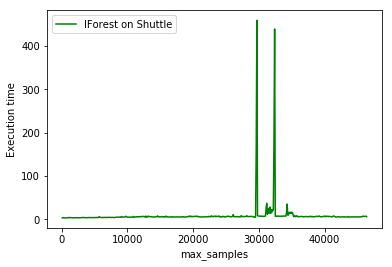

In [8]:
print("Execution time of IsolationForest applied on Shuttle (in second)")
print(averages_executions_time_IF_Shuttle)
plt.plot(range(100, len(X_Shuttle), 100), averages_executions_time_IF_Shuttle,  "g-", label="IForest on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('max_samples')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

ROC AUC for Isolation Forest applied on Shuttle
[0.9484447329121447, 0.9513469547208425, 0.9533204655507571, 0.9541330876571925, 0.9568053253771414, 0.9557583318700632, 0.9563387762318029, 0.9548318145472269, 0.9571535919941851, 0.9568031317211945, 0.9565709539764986, 0.956106598487107, 0.9571535919941851, 0.9573857697388809, 0.9570353094658902, 0.9569192205935424, 0.956106598487107, 0.9565709539764986, 0.9572696808665331, 0.9558744207424111, 0.9569214142494893, 0.9574996649552818, 0.9559905096147591, 0.9562226873594549, 0.9562226873594549, 0.9564548651041507, 0.9558744207424111, 0.9558744207424111, 0.9554100652530194, 0.9552939763806716, 0.9542513701854873, 0.9557605255260102, 0.9565709539764986, 0.956106598487107, 0.9559927032707061, 0.9545974431465841, 0.9558744207424112, 0.9558744207424111, 0.9563431635436968, 0.9557583318700632, 0.9556444366536623, 0.9554100652530195, 0.9565709539764986, 0.9556422429977153, 0.9551778875083236, 0.9552939763806716, 0.9552939763806716, 0.955293976380

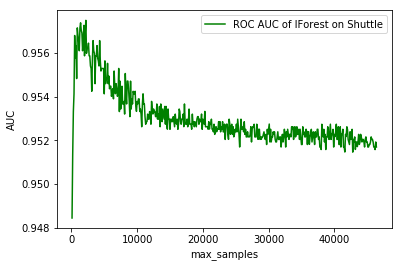

In [9]:
print("ROC AUC for Isolation Forest applied on Shuttle")
print(averages_roc_auc_IF_Shuttle)
print("La valeur max est "+str(max(averages_roc_auc_IF_Shuttle))+" à l'index "+str(averages_roc_auc_IF_Shuttle.index(max(averages_roc_auc_IF_Shuttle))))
plt.plot(range(100, len(X_Shuttle), 100), averages_roc_auc_IF_Shuttle,  "g-", label="ROC AUC of IForest on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('max_samples')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Interprétation du résultat de IsolationForest sur Shuttle

###### Faisant varier n_estimators
Le temps d'exécution de IForest n'est pas lié à la variation de contamination (le taux d'anomalies dans le jeu de données).
Par contre en ce qui concerne l'aire sous la coube ROC, la meilleure performance est arrivée quand contamination est à 0,1. 0,1 est d'ailleurs la valeur par défaut de contamination au niveau de scikit-learn.
Conclusion: Refaire l'exercice en faisant varier cette fois-ci n_estimators (le nombre d'estimateurs de l'emsemble à utiliser pour tester l'aberrance des observations).

Avec n_estimators entre 50 et 300, on remarque que le temps d'exécution augmente au fur et à mesure que le nombre d'estimateurs augmente. Concernant la performance, la meilleure estimation a été obtenu pour un taux de AUC = 0.9530882878060613 avec n_estimators = 70 ===> (50+2*10)
A noter que quelque soit la valeur de n_estimators, la AUC est toujours supérieure à 0,95


Avec n_estimators entre 10 et 300, on remarque que le temps d'exécution augmente au fur et à mesure que le nombre d'estimateurs augmente. Concernant la performance, la meilleure estimation a été obtenu pour un taux de AUC = 0.9540169987848446 avec n_estimators = 90 ===> ((8+1)*10) avec un CPU Time de 3.2488044261932374
A noter que quelque soit la valeur de n_estimators, la AUC est toujours supérieure à 0,95

###### Faisant varier max_samples
Avec max_samples entre 100 et len(X_Shuttle) pas 100, le temps d'exécution reste assez constant soit ]3,8] sauf quelques cas très minoritaires de hausse.
Considérant l'aire sous la courbe ROC, celle-ci a atteint sa plus haute valeur soit 0.9574996649552818 à max_samples = 2200((21+1)*100) après quoi la qualité de la prédiction a diminué. Néanmoins, il faut noter qu'en général, la AUC est toujours supérieure à 0,95.

### Exécution de OC-SVM sur Shuttle

In [19]:
averages_executions_time_OCSVM_Shuttle = []
averages_roc_auc_OCSVM_Shuttle = []

for j in frange(0.1, 1., 0.1):
    nu = j
    executions_time_OCSVM_Shuttle = []
    roc_auc_OCSVM_Shuttle = []
    for i in range(5):
        start_OCSVM_Shuttle = time()
        
        func_OCSVM_Shuttle = OneClassSVM(nu=nu)
        func_OCSVM_Shuttle.fit(X_Shuttle)
        y_pred_OCSVM_Shuttle = func_OCSVM_Shuttle.predict(X_Shuttle)

        # Calcul du temps d'exécution
        exec_time_OCSVM_Shuttle = time() - start_OCSVM_Shuttle
        executions_time_OCSVM_Shuttle.append(exec_time_OCSVM_Shuttle)

        # Calcul de l'aire sous la courbe ROC
        auc_OCSVM_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_OCSVM_Shuttle)
        roc_auc_OCSVM_Shuttle.append(auc_OCSVM_Shuttle)
        
    print("Execution time of OC-SVM applied on Shuttle (in second)")
    print(executions_time_OCSVM_Shuttle)
    print("ROC AUC for OC-SVM applied on Shuttle")
    print(roc_auc_OCSVM_Shuttle)
    averages_executions_time_OCSVM_Shuttle.append(statistics.mean(executions_time_OCSVM_Shuttle))
    averages_roc_auc_OCSVM_Shuttle.append(statistics.mean(roc_auc_OCSVM_Shuttle))

/Users/thesard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: numpy.arange
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' o

Execution time of OC-SVM applied on Shuttle (in second)
[329.46220993995667, 261.47730708122253, 274.28071904182434, 245.17911291122437, 240.5820107460022]
ROC AUC for OC-SVM applied on Shuttle
[0.6188546777389493, 0.6188546777389493, 0.6188546777389493, 0.6188546777389493, 0.6188546777389493]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[218.47312903404236, 216.3624849319458, 214.21477723121643, 215.6682789325714, 214.08669090270996]
ROC AUC for OC-SVM applied on Shuttle
[0.7269955947990666, 0.7269955947990666, 0.7269955947990666, 0.7269955947990666, 0.7269955947990666]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[191.5847761631012, 184.71183609962463, 180.26945781707764, 189.2221701145172, 181.08830785751343]
ROC AUC for OC-SVM applied on Shuttle
[0.7737174183377845, 0.7737174183377845, 0.7737174183377845, 0.7737174183377845, 0.7737174183377845]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[161.18653416633606, 160.5630328655243, 160.26079177856445, 160.88182997703552, 161.40579509735107]
ROC AUC for OC-SVM applied on Shuttle
[0.775169428691041, 0.775169428691041, 0.775169428691041, 0.775169428691041, 0.775169428691041]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[150.68664383888245, 150.58169770240784, 148.8878152370453, 148.7774007320404, 149.51005792617798]
ROC AUC for OC-SVM applied on Shuttle
[0.7442227397273692, 0.7442227397273692, 0.7442227397273692, 0.7442227397273692, 0.7442227397273692]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[141.95292973518372, 141.27181887626648, 148.45246386528015, 145.09825491905212, 144.94975304603577]
ROC AUC for OC-SVM applied on Shuttle
[0.7015329207794384, 0.7015329207794384, 0.7015329207794384, 0.7015329207794384, 0.7015329207794384]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[138.45889115333557, 136.31735110282898, 136.81975293159485, 138.9244029521942, 143.10618805885315]
ROC AUC for OC-SVM applied on Shuttle
[0.6525248979949985, 0.6525248979949985, 0.6525248979949985, 0.6525248979949985, 0.6525248979949985]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[121.23537707328796, 121.62225794792175, 121.03575110435486, 122.10104298591614, 121.69169592857361]
ROC AUC for OC-SVM applied on Shuttle
[0.601708857982714, 0.601708857982714, 0.601708857982714, 0.601708857982714, 0.601708857982714]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[119.410649061203, 112.79455494880676, 117.11709904670715, 111.87071490287781, 120.11324286460876]
ROC AUC for OC-SVM applied on Shuttle
[0.5511121835651296, 0.5511121835651296, 0.5511121835651296, 0.5511121835651296, 0.5511121835651296]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packa

Execution time of OC-SVM applied on Shuttle (in second)
[107.6783459186554, 108.68707871437073, 107.13427805900574, 111.51461815834045, 108.39957904815674]
ROC AUC for OC-SVM applied on Shuttle
[0.5, 0.5, 0.5, 0.5, 0.5]


### Résultat de OC-SVM sur shuttle

Execution time of OC-SVM applied on Shuttle (in second)
[270.19627194404603, 215.7610722064972, 185.37530961036683, 160.8595967769623, 149.6887230873108, 144.34504408836364, 138.72531723976135, 121.53722500801086, 116.2612521648407, 108.68277997970581]


/Users/thesard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: numpy.arange
  This is separate from the ipykernel package so we can avoid doing imports until


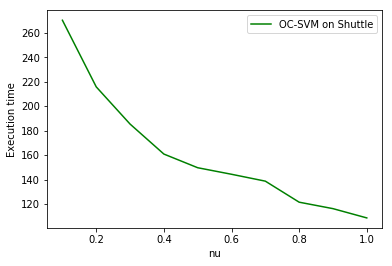

In [22]:
print("Execution time of OC-SVM applied on Shuttle (in second)")
print(averages_executions_time_OCSVM_Shuttle)
plt.plot(frange(0.1, 1., 0.1), averages_executions_time_OCSVM_Shuttle,  "g-", label="OC-SVM on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('nu')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

ROC AUC for OC-SVM applied on Shuttle
[0.6188546777389493, 0.7269955947990666, 0.7737174183377845, 0.775169428691041, 0.7442227397273692, 0.7015329207794384, 0.6525248979949985, 0.601708857982714, 0.5511121835651296, 0.5]


/Users/thesard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: numpy.arange
  This is separate from the ipykernel package so we can avoid doing imports until


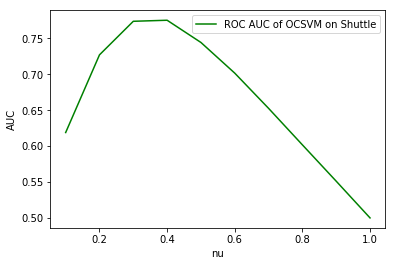

In [25]:
print("ROC AUC for OC-SVM applied on Shuttle")
print(averages_roc_auc_OCSVM_Shuttle)
plt.plot(frange(0.1, 1., 0.1), averages_roc_auc_OCSVM_Shuttle,  "g-", label="ROC AUC of OCSVM on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('nu')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Interprétation du résultat de OC-SVM sur Shuttle

Plus la valeur de nu augmente plus le temps d'exécution diminue. OC-SVM est donc plus rapide sur Shuttle avec un nu plus grand.
Mais, celà n'entraîne pas un bon résultat de la méthode. Puisqu'à partir d'un nu de 0.5, la prédiction de l'algorithme devient de plus en plus aléatoire. La meilleure performance est atteinte à nu= 0.4

### Exécution de LOF sur Shuttle

In [35]:
averages_executions_time_LOF_Shuttle = []
averages_roc_auc_LOF_Shuttle = []

for j in range(5, 200, 5):
    n_neighbors = j
    executions_time_LOF_Shuttle = []
    roc_auc_LOF_Shuttle = []
    for i in range(5):
        start_LOF_Shuttle = time()
        
        func_LOF_Shuttle = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
        func_LOF_Shuttle.fit(X_Shuttle)
        y_pred_LOF_Shuttle = func_LOF_Shuttle.predict(X_Shuttle)

        # Calcul du temps d'exécution
        exec_time_LOF_Shuttle = time() - start_LOF_Shuttle
        executions_time_LOF_Shuttle.append(exec_time_LOF_Shuttle)

        # Calcul de l'aire sous la courbe ROC
        auc_LOF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_LOF_Shuttle)
        roc_auc_LOF_Shuttle.append(auc_LOF_Shuttle)
        
    print("Execution time of LOF applied on Shuttle (in second)")
    print(executions_time_LOF_Shuttle)
    print("ROC AUC for LOF applied on Shuttle")
    print(roc_auc_LOF_Shuttle)
    averages_executions_time_LOF_Shuttle.append(statistics.mean(executions_time_LOF_Shuttle))
    averages_roc_auc_LOF_Shuttle.append(statistics.mean(roc_auc_LOF_Shuttle))


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[8.548911094665527, 7.140587091445923, 6.541306972503662, 6.311285018920898, 6.982913017272949]
ROC AUC for LOF applied on Shuttle
[0.5215160920903762, 0.5215160920903762, 0.5215160920903762, 0.5215160920903762, 0.5215160920903762]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[8.106007814407349, 10.845497131347656, 9.745582818984985, 8.954133987426758, 9.703468084335327]
ROC AUC for LOF applied on Shuttle
[0.5303294171661024, 0.5303294171661024, 0.5303294171661024, 0.5303294171661024, 0.5303294171661024]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[10.239574193954468, 10.467014074325562, 10.775267124176025, 10.272745132446289, 10.155516147613525]
ROC AUC for LOF applied on Shuttle
[0.5464129627777061, 0.5464129627777061, 0.5464129627777061, 0.5464129627777061, 0.5464129627777061]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[11.09737491607666, 11.359040021896362, 12.265018939971924, 11.640704870223999, 11.218759775161743]
ROC AUC for LOF applied on Shuttle
[0.5597715279848037, 0.5597715279848037, 0.5597715279848037, 0.5597715279848037, 0.5597715279848037]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[12.55742621421814, 11.96461796760559, 12.57378101348877, 13.2724769115448, 12.296541929244995]
ROC AUC for LOF applied on Shuttle
[0.5707113501557596, 0.5707113501557596, 0.5707113501557596, 0.5707113501557596, 0.5707113501557596]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[14.968611001968384, 15.172990322113037, 15.481447219848633, 12.923413276672363, 13.751121997833252]
ROC AUC for LOF applied on Shuttle
[0.5833266957335241, 0.5833266957335241, 0.5833266957335241, 0.5833266957335241, 0.5833266957335241]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[13.90953803062439, 13.948063850402832, 13.774773836135864, 14.092037916183472, 13.781497240066528]
ROC AUC for LOF applied on Shuttle
[0.6071569449398353, 0.6071569449398353, 0.6071569449398353, 0.6071569449398353, 0.6071569449398353]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[15.525487184524536, 15.68483567237854, 15.388175964355469, 15.29531216621399, 16.37880516052246]
ROC AUC for LOF applied on Shuttle
[0.6206598467119195, 0.6206598467119195, 0.6206598467119195, 0.6206598467119195, 0.6206598467119195]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[17.36264991760254, 25.102497816085815, 21.20089888572693, 16.928543090820312, 20.417612075805664]
ROC AUC for LOF applied on Shuttle
[0.6278985115819538, 0.6278985115819538, 0.6278985115819538, 0.6278985115819538, 0.6278985115819538]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[22.502599954605103, 19.250303030014038, 22.29130983352661, 23.096499919891357, 17.23454785346985]
ROC AUC for LOF applied on Shuttle
[0.6358931132894875, 0.6358931132894875, 0.6358931132894875, 0.6358931132894875, 0.6358931132894875]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[20.515130043029785, 18.800599813461304, 18.7432541847229, 20.603824853897095, 20.3718318939209]
ROC AUC for LOF applied on Shuttle
[0.6389370482705246, 0.6389370482705246, 0.6389370482705246, 0.6389370482705246, 0.6389370482705246]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[19.592599153518677, 20.091093063354492, 17.522411108016968, 17.463611841201782, 20.06765127182007]
ROC AUC for LOF applied on Shuttle
[0.6446098725311001, 0.6446098725311001, 0.6446098725311001, 0.6446098725311001, 0.6446098725311001]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[20.842701196670532, 24.88567304611206, 26.10126519203186, 23.518700122833252, 20.749629020690918]
ROC AUC for LOF applied on Shuttle
[0.6439855550504205, 0.6439855550504205, 0.6439855550504205, 0.6439855550504205, 0.6439855550504205]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[19.079163789749146, 19.068058013916016, 19.510679721832275, 20.462062120437622, 19.97934603691101]
ROC AUC for LOF applied on Shuttle
[0.6452341900117797, 0.6452341900117797, 0.6452341900117797, 0.6452341900117797, 0.6452341900117797]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[19.98332905769348, 20.267674922943115, 29.37620520591736, 25.0815589427948, 22.414516925811768]
ROC AUC for LOF applied on Shuttle
[0.6454746177017341, 0.6454746177017341, 0.6454746177017341, 0.6454746177017341, 0.6454746177017341]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[22.203749179840088, 22.69283699989319, 23.070982933044434, 22.550247192382812, 23.32349419593811]
ROC AUC for LOF applied on Shuttle
[0.6455513956598792, 0.6455513956598792, 0.6455513956598792, 0.6455513956598792, 0.6455513956598792]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[22.011680126190186, 21.317906141281128, 23.827029943466187, 28.214295148849487, 24.37269616127014]
ROC AUC for LOF applied on Shuttle
[0.6433274582663202, 0.6433274582663202, 0.6433274582663202, 0.6433274582663202, 0.6433274582663202]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[23.76908278465271, 23.217936992645264, 23.408956050872803, 23.79703998565674, 22.809025049209595]
ROC AUC for LOF applied on Shuttle
[0.6452223472678289, 0.6452223472678289, 0.6452223472678289, 0.6452223472678289, 0.6452223472678289]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[24.00037717819214, 23.512400150299072, 32.20188522338867, 25.832989931106567, 26.433369159698486]
ROC AUC for LOF applied on Shuttle
[0.6439846805862048, 0.6439846805862048, 0.6439846805862048, 0.6439846805862048, 0.6439846805862048]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[28.55326795578003, 23.9446861743927, 26.600772857666016, 24.454368114471436, 25.80253291130066]
ROC AUC for LOF applied on Shuttle
[0.6426153945477606, 0.6426153945477606, 0.6426153945477606, 0.6426153945477606, 0.6426153945477606]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[24.520621061325073, 25.380983114242554, 25.671968936920166, 26.67810082435608, 26.24145793914795]
ROC AUC for LOF applied on Shuttle
[0.6397022044593278, 0.6397022044593278, 0.6397022044593278, 0.6397022044593278, 0.6397022044593278]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[31.295750856399536, 27.675748109817505, 29.594388961791992, 28.73183512687683, 22.946579933166504]
ROC AUC for LOF applied on Shuttle
[0.6340622850379573, 0.6340622850379573, 0.6340622850379573, 0.6340622850379573, 0.6340622850379573]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[23.47481083869934, 23.13122034072876, 23.193423986434937, 822.1039469242096, 25.384517908096313]
ROC AUC for LOF applied on Shuttle
[0.6311600632292595, 0.6311600632292595, 0.6311600632292595, 0.6311600632292595, 0.6311600632292595]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[1755.7952139377594, 26.021297931671143, 36.12047481536865, 24.064188957214355, 24.732654094696045]
ROC AUC for LOF applied on Shuttle
[0.6276554604993521, 0.6276554604993521, 0.6276554604993521, 0.6276554604993521, 0.6276554604993521]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[29.610510110855103, 25.375948190689087, 26.24496293067932, 26.375334978103638, 32.57053589820862]
ROC AUC for LOF applied on Shuttle
[0.6256837935396983, 0.6256837935396983, 0.6256837935396983, 0.6256837935396983, 0.6256837935396983]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[28.53094506263733, 27.911957025527954, 27.77123212814331, 26.486833333969116, 28.033424854278564]
ROC AUC for LOF applied on Shuttle
[0.6253665878915988, 0.6253665878915988, 0.6253665878915988, 0.6253665878915988, 0.6253665878915988]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[32.20329809188843, 33.18260097503662, 28.63064217567444, 28.9147789478302, 30.17589807510376]
ROC AUC for LOF applied on Shuttle
[0.6239314921747445, 0.6239314921747445, 0.6239314921747445, 0.6239314921747445, 0.6239314921747445]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[33.00988006591797, 31.16098117828369, 29.51857304573059, 29.466418981552124, 28.89672613143921]
ROC AUC for LOF applied on Shuttle
[0.6199341913209777, 0.6199341913209777, 0.6199341913209777, 0.6199341913209777, 0.6199341913209777]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[33.044429779052734, 29.72644305229187, 30.903799057006836, 29.281348943710327, 35.302117109298706]
ROC AUC for LOF applied on Shuttle
[0.6152138584689161, 0.6152138584689161, 0.6152138584689161, 0.6152138584689161, 0.6152138584689161]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[33.06908082962036, 34.36426019668579, 32.27237606048584, 31.718379020690918, 34.16162896156311]
ROC AUC for LOF applied on Shuttle
[0.6070766691248273, 0.6070766691248273, 0.6070766691248273, 0.6070766691248273, 0.6070766691248273]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[29.008259057998657, 28.686951875686646, 37.20945692062378, 34.627143144607544, 31.784306287765503]
ROC AUC for LOF applied on Shuttle
[0.600604034907812, 0.600604034907812, 0.600604034907812, 0.600604034907812, 0.600604034907812]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[30.09407091140747, 31.068660974502563, 31.05798602104187, 30.35109782218933, 30.627393007278442]
ROC AUC for LOF applied on Shuttle
[0.5925326552421332, 0.5925326552421332, 0.5925326552421332, 0.5925326552421332, 0.5925326552421332]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[30.898460865020752, 32.192503929138184, 31.596322774887085, 30.930474996566772, 32.383541107177734]
ROC AUC for LOF applied on Shuttle
[0.5804420381632174, 0.5804420381632174, 0.5804420381632174, 0.5804420381632174, 0.5804420381632174]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[31.535628080368042, 29.67800807952881, 31.008280038833618, 29.331932067871094, 29.513152837753296]
ROC AUC for LOF applied on Shuttle
[0.5716147216600389, 0.5716147216600389, 0.5716147216600389, 0.5716147216600389, 0.5716147216600389]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[31.129746198654175, 29.830172061920166, 31.112814903259277, 30.072266101837158, 29.939199209213257]
ROC AUC for LOF applied on Shuttle
[0.5646713258786342, 0.5646713258786342, 0.5646713258786342, 0.5646713258786342, 0.5646713258786342]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[31.273830890655518, 30.44507074356079, 37.11281681060791, 34.68531513214111, 31.82643485069275]
ROC AUC for LOF applied on Shuttle
[0.5561072480890957, 0.5561072480890957, 0.5561072480890957, 0.5561072480890957, 0.5561072480890957]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[33.049050092697144, 35.441572189331055, 43.89703392982483, 41.15648293495178, 41.83665609359741]
ROC AUC for LOF applied on Shuttle
[0.547893280786862, 0.547893280786862, 0.547893280786862, 0.547893280786862, 0.547893280786862]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[33.169673919677734, 34.13337707519531, 34.74171185493469, 33.59257698059082, 33.5199248790741]
ROC AUC for LOF applied on Shuttle
[0.5385403613206189, 0.5385403613206189, 0.5385403613206189, 0.5385403613206189, 0.5385403613206189]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied on Shuttle (in second)
[34.08888387680054, 32.08362698554993, 32.52544093132019, 35.860275745391846, 36.32122993469238]
ROC AUC for LOF applied on Shuttle
[0.5299433786918755, 0.5299433786918755, 0.5299433786918755, 0.5299433786918755, 0.5299433786918755]


### Résultat de LOF sur shuttle

Execution time of LOF applied on Shuttle (in second)
[7.105000638961792, 9.470937967300415, 10.382023334503174, 11.516179704666138, 12.53296880722046, 14.459516763687134, 13.901182174682617, 15.654523229598999, 20.202440357208253, 20.87505211830139, 19.806928157806396, 18.947473287582397, 23.219593715667724, 19.619861936569215, 23.424657011032103, 22.768262100219726, 23.948721504211427, 23.40040817260742, 26.39620432853699, 25.871125602722167, 25.698626375198366, 28.048860597610474, 183.45758399963378, 373.3467659473419, 28.035458421707155, 27.746878480911256, 30.621443653106688, 30.410515880584718, 31.651627588272095, 33.11714501380921, 32.26322345733642, 30.639841747283935, 31.600260734558105, 30.213400220870973, 30.416839694976808, 33.06869368553161, 39.07615904808044, 33.83145294189453, 34.17589149475098]


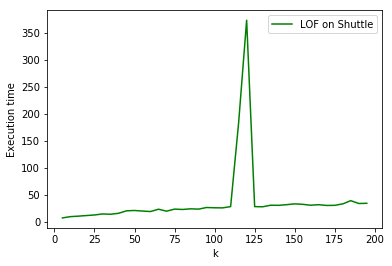

In [51]:
print("Execution time of LOF applied on Shuttle (in second)")
print(averages_executions_time_LOF_Shuttle)
plt.plot(range(5, 200, 5), averages_executions_time_LOF_Shuttle,  "g-", label="LOF on Shuttle")
#plt.axis([0, 200, 0, 200])
plt.xlabel('k')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

ROC AUC for LOF applied on Shuttle
[0.5215160920903762, 0.5303294171661024, 0.5464129627777061, 0.5597715279848037, 0.5707113501557596, 0.5833266957335241, 0.6071569449398353, 0.6206598467119195, 0.6278985115819538, 0.6358931132894875, 0.6389370482705246, 0.6446098725311001, 0.6439855550504205, 0.6452341900117797, 0.6454746177017341, 0.6455513956598792, 0.6433274582663202, 0.6452223472678289, 0.6439846805862048, 0.6426153945477606, 0.6397022044593278, 0.6340622850379573, 0.6311600632292595, 0.6276554604993521, 0.6256837935396983, 0.6253665878915988, 0.6239314921747445, 0.6199341913209777, 0.6152138584689161, 0.6070766691248273, 0.600604034907812, 0.5925326552421332, 0.5804420381632174, 0.5716147216600389, 0.5646713258786342, 0.5561072480890957, 0.547893280786862, 0.5385403613206189, 0.5299433786918755]
La valeur max est 0.6455513956598792 à l'index 15


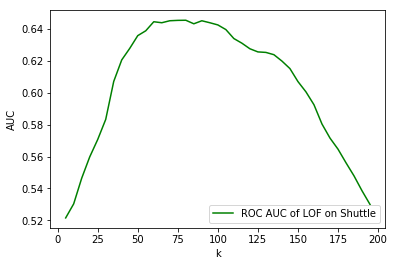

In [52]:
print("ROC AUC for LOF applied on Shuttle")
print(averages_roc_auc_LOF_Shuttle)
print("La valeur max est "+str(max(averages_roc_auc_LOF_Shuttle))+" à l'index "+str(averages_roc_auc_LOF_Shuttle.index(max(averages_roc_auc_LOF_Shuttle))))
plt.plot(range(5, 200, 5), averages_roc_auc_LOF_Shuttle,  "g-", label="ROC AUC of LOF on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('k')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Interprétation du résultat de LOF sur Shuttle

Plus le nombre de n_neighbors augmente, plus de temps d'éxécution est important. Ceci s'explique par le fait que plus le nombre de voisins à considérer est grand plus il faudra calculer les distances et les densité afin d'estimer le degré d'abberrance d'une observation.
Concernant la performance de la méthode, elle atteint son plus fort (AUC = 0.6455513956598792) à taux à n_estimators= 80 ((15+1)*5) pour un temps d'exécution de 22.768262100219726

In [5]:
averages_executions_time_LOF_Shuttle_fitPredict = []
averages_roc_auc_LOF_Shuttle_fitPredict = []

for j in range(5, 200, 5):
    n_neighbors = j
    executions_time_LOF_Shuttle_fitPredict = []
    roc_auc_LOF_Shuttle_fitPredict = []
    for i in range(5):
        start_LOF_Shuttle_fitPredict = time()
        
        func_LOF_Shuttle_fitPredict = LocalOutlierFactor(n_neighbors=n_neighbors)
        #func_LOF_Shuttle.fit(X_Shuttle)
        y_pred_LOF_Shuttle_fitPredict = func_LOF_Shuttle_fitPredict.fit_predict(X_Shuttle)

        # Calcul du temps d'exécution
        exec_time_LOF_Shuttle_fitPredict = time() - start_LOF_Shuttle_fitPredict
        executions_time_LOF_Shuttle_fitPredict.append(exec_time_LOF_Shuttle_fitPredict)

        # Calcul de l'aire sous la courbe ROC
        auc_LOF_Shuttle_fitPredict = roc_auc_score(y_transform_Shuttle, y_pred_LOF_Shuttle_fitPredict)
        roc_auc_LOF_Shuttle_fitPredict.append(auc_LOF_Shuttle_fitPredict)
        
    print("Execution time of LOF applied fitPredict on Shuttle (in second)")
    print(executions_time_LOF_Shuttle_fitPredict)
    print("ROC AUC for LOF applied fitPredict on Shuttle")
    print(roc_auc_LOF_Shuttle_fitPredict)
    averages_executions_time_LOF_Shuttle_fitPredict.append(statistics.mean(executions_time_LOF_Shuttle_fitPredict))
    averages_roc_auc_LOF_Shuttle_fitPredict.append(statistics.mean(roc_auc_LOF_Shuttle_fitPredict))


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[6.2639570236206055, 6.150643825531006, 6.120585918426514, 4.922743082046509, 4.789489030838013]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5366775026940993, 0.5366775026940993, 0.5366775026940993, 0.5366775026940993, 0.5366775026940993]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[7.137811183929443, 7.112905979156494, 7.256501197814941, 6.4198267459869385, 7.721999883651733]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5337752808854015, 0.5337752808854015, 0.5337752808854015, 0.5337752808854015, 0.5337752808854015]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[8.534732818603516, 8.546464920043945, 10.309387922286987, 11.044346809387207, 9.801023960113525]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5494472786523698, 0.5494472786523698, 0.5494472786523698, 0.5494472786523698, 0.5494472786523698]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[8.965462923049927, 8.604393243789673, 8.601096153259277, 8.615767240524292, 8.571898937225342]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5627974989723796, 0.5627974989723796, 0.5627974989723796, 0.5627974989723796, 0.5627974989723796]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[9.43875002861023, 9.815952062606812, 9.423255920410156, 10.36380386352539, 9.737160921096802]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5749868305689104, 0.5749868305689104, 0.5749868305689104, 0.5749868305689104, 0.5749868305689104]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[10.14114260673523, 10.111436128616333, 10.113987922668457, 10.115614891052246, 12.810058116912842]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5976241606767534, 0.5976241606767534, 0.5976241606767534, 0.5976241606767534, 0.5976241606767534]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[12.409297227859497, 12.285495042800903, 12.210142850875854, 12.393171787261963, 13.459729194641113]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6191006020611172, 0.6191006020611172, 0.6191006020611172, 0.6191006020611172, 0.6191006020611172]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[11.617873191833496, 12.539975881576538, 17.015907049179077, 15.063608169555664, 13.771650075912476]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6266463787637315, 0.6266463787637315, 0.6266463787637315, 0.6266463787637315, 0.6266463787637315]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[13.029826164245605, 14.426953077316284, 15.269773006439209, 17.185853004455566, 32.61293411254883]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6336117111046062, 0.6336117111046062, 0.6336117111046062, 0.6336117111046062, 0.6336117111046062]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[17.34407091140747, 18.449026107788086, 16.8475079536438, 17.685969829559326, 17.03342628479004]
ROC AUC for LOF applied fitPredict on Shuttle
[0.64173793216896, 0.64173793216896, 0.64173793216896, 0.64173793216896, 0.64173793216896]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[16.666094064712524, 14.547420024871826, 14.102967023849487, 15.349633932113647, 16.54792809486389]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6399965990837414, 0.6399965990837414, 0.6399965990837414, 0.6399965990837414, 0.6399965990837414]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[16.001083850860596, 13.953073978424072, 16.576987981796265, 18.04191780090332, 16.54656720161438]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6452205983393975, 0.6452205983393975, 0.6452205983393975, 0.6452205983393975, 0.6452205983393975]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[17.493186712265015, 16.15676498413086, 14.66373872756958, 15.22176194190979, 16.296419858932495]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6440597096159184, 0.6440597096159184, 0.6440597096159184, 0.6440597096159184, 0.6440597096159184]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[20.077375173568726, 18.318805932998657, 17.59625506401062, 15.317426919937134, 19.080501079559326]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6446401539776578, 0.6446401539776578, 0.6446401539776578, 0.6446401539776578, 0.6446401539776578]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[20.372090101242065, 21.017306327819824, 23.05502200126648, 15.882473945617676, 17.12255597114563]
ROC AUC for LOF applied fitPredict on Shuttle
[0.645801042701137, 0.645801042701137, 0.645801042701137, 0.645801042701137, 0.645801042701137]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[16.230268955230713, 16.20698118209839, 16.284451246261597, 16.029670000076294, 18.455278158187866]
ROC AUC for LOF applied fitPredict on Shuttle
[0.645801042701137, 0.645801042701137, 0.645801042701137, 0.645801042701137, 0.645801042701137]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[23.928452968597412, 19.40214490890503, 19.75869917869568, 19.38458514213562, 18.383816957473755]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6440597096159184, 0.6440597096159184, 0.6440597096159184, 0.6440597096159184, 0.6440597096159184]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[19.87593698501587, 17.64606499671936, 22.475360870361328, 17.239931106567383, 18.338455200195312]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6463814870628766, 0.6463814870628766, 0.6463814870628766, 0.6463814870628766, 0.6463814870628766]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[17.168665885925293, 17.61018705368042, 28.16833996772766, 19.764774322509766, 17.88312792778015]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6446401539776578, 0.6446401539776578, 0.6446401539776578, 0.6446401539776578, 0.6446401539776578]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[17.741116285324097, 19.410027980804443, 20.165122985839844, 20.86373209953308, 21.085635900497437]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6423183765306997, 0.6423183765306997, 0.6423183765306997, 0.6423183765306997, 0.6423183765306997]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[21.67599606513977, 21.829285144805908, 21.26392889022827, 22.54395604133606, 19.845826864242554]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6399965990837414, 0.6399965990837414, 0.6399965990837414, 0.6399965990837414, 0.6399965990837414]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[22.34662914276123, 22.37143611907959, 19.462400197982788, 22.24277663230896, 23.071624755859375]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6359334885515644, 0.6359334885515644, 0.6359334885515644, 0.6359334885515644, 0.6359334885515644]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[22.46181321144104, 24.243808031082153, 19.922592878341675, 23.117843866348267, 18.674078941345215]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6318703780193875, 0.6318703780193875, 0.6318703780193875, 0.6318703780193875, 0.6318703780193875]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[17.940247774124146, 17.783019065856934, 18.568716049194336, 43.48970007896423, 29.512925148010254]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6301290449341688, 0.6301290449341688, 0.6301290449341688, 0.6301290449341688, 0.6301290449341688]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[23.75527286529541, 29.264535188674927, 22.92527174949646, 20.828255891799927, 20.228557109832764]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6249050456785128, 0.6249050456785128, 0.6249050456785128, 0.6249050456785128, 0.6249050456785128]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[23.926175832748413, 21.136569261550903, 21.965434074401855, 20.79287075996399, 21.73565125465393]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6249050456785128, 0.6249050456785128, 0.6249050456785128, 0.6249050456785128, 0.6249050456785128]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[27.17577290534973, 27.0945987701416, 23.23072624206543, 21.521471977233887, 20.648605823516846]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6231637125932941, 0.6231637125932941, 0.6231637125932941, 0.6231637125932941, 0.6231637125932941]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[22.455617666244507, 24.267590045928955, 27.392186164855957, 22.2690691947937, 24.827516078948975]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6202614907845962, 0.6202614907845962, 0.6202614907845962, 0.6202614907845962, 0.6202614907845962]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[23.63966989517212, 26.9871768951416, 25.582520961761475, 25.208393096923828, 22.831233024597168]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6161983802524194, 0.6161983802524194, 0.6161983802524194, 0.6161983802524194, 0.6161983802524194]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[22.48629093170166, 29.966890811920166, 29.154091119766235, 20.51272201538086, 20.675346851348877]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6098134922732841, 0.6098134922732841, 0.6098134922732841, 0.6098134922732841, 0.6098134922732841]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[21.208412885665894, 1210.2186441421509, 34.20415210723877, 26.596996068954468, 26.911269903182983]
ROC AUC for LOF applied fitPredict on Shuttle
[0.6011068268471907, 0.6011068268471907, 0.6011068268471907, 0.6011068268471907, 0.6011068268471907]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[24.779940843582153, 24.96441102027893, 28.52423596382141, 28.283670902252197, 32.93068814277649]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5918197170593578, 0.5918197170593578, 0.5918197170593578, 0.5918197170593578, 0.5918197170593578]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[29.16030192375183, 25.100205659866333, 30.966818809509277, 24.758387088775635, 27.08087396621704]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5802108298245665, 0.5802108298245665, 0.5802108298245665, 0.5802108298245665, 0.5802108298245665]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[27.946221113204956, 30.536000967025757, 28.90926218032837, 27.16851282119751, 29.864578008651733]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5709237200367335, 0.5709237200367335, 0.5709237200367335, 0.5709237200367335, 0.5709237200367335]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[31.439106702804565, 27.41464900970459, 29.959768056869507, 31.04922318458557, 22.40795397758484]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5645388320575984, 0.5645388320575984, 0.5645388320575984, 0.5645388320575984, 0.5645388320575984]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[21.693238973617554, 21.83808994293213, 90.31403303146362, 186.81009221076965, 34.08453321456909]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5558321666315049, 0.5558321666315049, 0.5558321666315049, 0.5558321666315049, 0.5558321666315049]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[22.89810299873352, 22.29163098335266, 25.9563570022583, 23.770857095718384, 28.354638814926147]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5482863899288906, 0.5482863899288906, 0.5482863899288906, 0.5482863899288906, 0.5482863899288906]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[30.83831000328064, 27.566961765289307, 27.538749933242798, 24.748005867004395, 22.314210891723633]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5378383914175784, 0.5378383914175784, 0.5378383914175784, 0.5378383914175784, 0.5378383914175784]


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/skl

Execution time of LOF applied fitPredict on Shuttle (in second)
[28.9795138835907, 26.009949922561646, 25.384615898132324, 24.71794104576111, 24.891226768493652]
ROC AUC for LOF applied fitPredict on Shuttle
[0.5302926147149641, 0.5302926147149641, 0.5302926147149641, 0.5302926147149641, 0.5302926147149641]


### Résultat de LOF sur shuttle

Execution time of LOF applied _fitPredict on Shuttle (in second)
[5.649483776092529, 7.12980899810791, 9.647191286087036, 8.671723699569702, 9.755784559249879, 10.65844793319702, 12.551567220687867, 14.00180287361145, 18.5050678730011, 17.472000217437746, 15.442808628082275, 16.223926162719728, 15.966374444961549, 18.078072834014893, 19.489889669418336, 16.64132990837097, 20.1715398311615, 19.115149831771852, 20.119019031524658, 19.85312705039978, 21.43179860115051, 21.898973369598387, 21.68402738571167, 25.45892162322998, 23.4003785610199, 21.91134023666382, 23.9342351436615, 24.24239583015442, 24.84979877471924, 24.559068346023558, 263.8278950214386, 27.896589374542238, 27.413317489624024, 28.884915018081664, 28.454140186309814, 70.94799747467042, 24.654317378997803, 26.601247692108153, 25.996649503707886]


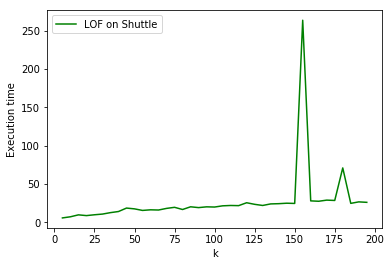

In [6]:
print("Execution time of LOF applied _fitPredict on Shuttle (in second)")
print(averages_executions_time_LOF_Shuttle_fitPredict)
plt.plot(range(5, 200, 5), averages_executions_time_LOF_Shuttle_fitPredict,  "g-", label="LOF on Shuttle")
#plt.axis([0, 200, 0, 200])
plt.xlabel('k')
plt.ylabel('Execution time')
plt.legend(loc="best")
plt.show()

ROC AUC for LOF applied fitPredict on Shuttle
[0.5366775026940993, 0.5337752808854015, 0.5494472786523698, 0.5627974989723796, 0.5749868305689104, 0.5976241606767534, 0.6191006020611172, 0.6266463787637315, 0.6336117111046062, 0.64173793216896, 0.6399965990837414, 0.6452205983393975, 0.6440597096159184, 0.6446401539776578, 0.645801042701137, 0.645801042701137, 0.6440597096159184, 0.6463814870628766, 0.6446401539776578, 0.6423183765306997, 0.6399965990837414, 0.6359334885515644, 0.6318703780193875, 0.6301290449341688, 0.6249050456785128, 0.6249050456785128, 0.6231637125932941, 0.6202614907845962, 0.6161983802524194, 0.6098134922732841, 0.6011068268471907, 0.5918197170593578, 0.5802108298245665, 0.5709237200367335, 0.5645388320575984, 0.5558321666315049, 0.5482863899288906, 0.5378383914175784, 0.5302926147149641]
La valeur max est 0.6463814870628766 à l'index 17


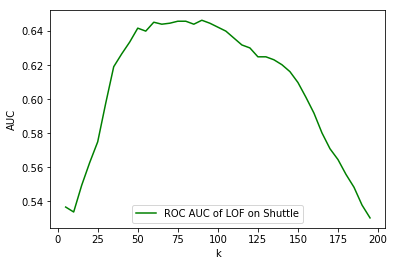

In [7]:
print("ROC AUC for LOF applied fitPredict on Shuttle")
print(averages_roc_auc_LOF_Shuttle_fitPredict)
print("La valeur max est "+str(max(averages_roc_auc_LOF_Shuttle_fitPredict))+" à l'index "+str(averages_roc_auc_LOF_Shuttle_fitPredict.index(max(averages_roc_auc_LOF_Shuttle_fitPredict))))
plt.plot(range(5, 200, 5), averages_roc_auc_LOF_Shuttle_fitPredict,  "g-", label="ROC AUC of LOF on Shuttle")
#plt.axis([0, 1, 0, 1])
plt.xlabel('k')
plt.ylabel('AUC')
plt.legend(loc="best")
plt.show()

### Interprétation du résultat de LOF sur Shuttle

Plus le nombre de n_neighbors augmente, plus de temps d'éxécution est important. Ceci s'explique par le fait que plus le nombre de voisins à considérer est grand plus il faudra calculer les distances et les densité afin d'estimer le degré d'abberrance d'une observation.
Concernant la performance de la méthode, elle atteint son plus fort (AUC = 0.6455513956598792) à taux à n_estimators= 80 ((15+1)*5) pour un temps d'exécution de 22.768262100219726

## Exécution des méthodes avec les meilleurs paramètres trouvés sur Shuttle

In [10]:
executions_time_Shuttle = []
methods = []

# Isolation Forest avec n_estimators
methods.append('IForest n_estimators')
start_time = time()
n_estimators = 90
func_IF_Shuttle = IsolationForest(n_estimators=n_estimators)
func_IF_Shuttle.fit(X_Shuttle)
y_pred_IF_Shuttle = func_IF_Shuttle.predict(X_Shuttle)
# Calcul du temps d'exécution
executions_time_Shuttle.append(time() - start_time)

# Isolation Forest avec max_samples
methods.append('IForest max_samples')
start_time = time()
max_samples = 2200
func_IF_Shuttle = IsolationForest(max_samples=max_samples)
func_IF_Shuttle.fit(X_Shuttle)
y_pred_IF_Shuttle_max_samples = func_IF_Shuttle.predict(X_Shuttle)
# Calcul du temps d'exécution
executions_time_Shuttle.append(time() - start_time)

# Isolation Forest avec max_samples et n_estimators
methods.append('IForest max_samples et n_estimators')
start_time = time()
n_estimators = 90
max_samples  = 2200
func_IF_Shuttle = IsolationForest(n_estimators=n_estimators, max_samples=max_samples)
func_IF_Shuttle.fit(X_Shuttle)
y_pred_IF_Shuttle_estimators_samples = func_IF_Shuttle.predict(X_Shuttle)
# Calcul du temps d'exécution
executions_time_Shuttle.append(time() - start_time)

# OC-SVM
methods.append('OC-SVM')
start_time = time()
nu = 0.4
func_OCSVM_Shuttle = OneClassSVM(nu=nu)
func_OCSVM_Shuttle.fit(X_Shuttle)
y_pred_OCSVM_Shuttle = func_OCSVM_Shuttle.predict(X_Shuttle)
# Calcul du temps d'exécution
executions_time_Shuttle.append(time() - start_time)

# LOF
methods.append('LOF')
start_time = time()
n_neighbors = 80
func_LOF_Shuttle = LocalOutlierFactor(n_neighbors=n_neighbors,novelty=True)
func_LOF_Shuttle.fit(X_Shuttle)
y_pred_LOF_Shuttle = func_LOF_Shuttle.predict(X_Shuttle)
# Calcul du temps d'exécution
executions_time_Shuttle.append(time() - start_time)

/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarni

### Calcul des valeurs des métriques de comparaison

In [11]:
precisions_Shuttle = []
recalls_Shuttle = []
roc_aucs_Shuttle = []
f1_scores_Shuttle = []

# Isolation Forest avec n_estimators
# Precision
precisions_Shuttle.append(precision_score(y_transform_Shuttle, y_pred_IF_Shuttle))
# Recall
recalls_Shuttle.append(recall_score(y_transform_Shuttle, y_pred_IF_Shuttle))
# f1_score
f1_scores_Shuttle.append(f1_score(y_transform_Shuttle, y_pred_IF_Shuttle))
# Calcul de l'aire sous la courbe ROC
auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_IF_Shuttle)
roc_aucs_Shuttle.append(auc_IF_Shuttle)
print("Confusion Matrice IForest avec n_estimators")
print(confusion_matrix(y_transform_Shuttle, y_pred_IF_Shuttle))

# Isolation Forest avec max_samples
# Precision
precisions_Shuttle.append(precision_score(y_transform_Shuttle, y_pred_IF_Shuttle_max_samples))
# Recall
recalls_Shuttle.append(recall_score(y_transform_Shuttle, y_pred_IF_Shuttle_max_samples))
# f1_score
f1_scores_Shuttle.append(f1_score(y_transform_Shuttle, y_pred_IF_Shuttle_max_samples))
# Calcul de l'aire sous la courbe ROC
auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_IF_Shuttle_max_samples)
roc_aucs_Shuttle.append(auc_IF_Shuttle)
print("Confusion Matrice IForest avec max_samples")
print(confusion_matrix(y_transform_Shuttle, y_pred_IF_Shuttle_max_samples))

# Isolation Forest avec max_samples et n_estimators
# Precision
precisions_Shuttle.append(precision_score(y_transform_Shuttle, y_pred_IF_Shuttle_estimators_samples))
# Recall
recalls_Shuttle.append(recall_score(y_transform_Shuttle, y_pred_IF_Shuttle_estimators_samples))
# f1_score
f1_scores_Shuttle.append(f1_score(y_transform_Shuttle, y_pred_IF_Shuttle_estimators_samples))
# Calcul de l'aire sous la courbe ROC
auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_IF_Shuttle_estimators_samples)
roc_aucs_Shuttle.append(auc_IF_Shuttle)
print("Confusion Matrice IForest avec max_samples et n_estimators")
print(confusion_matrix(y_transform_Shuttle, y_pred_IF_Shuttle_estimators_samples))

# OC-SVM
# Precision
precisions_Shuttle.append(precision_score(y_transform_Shuttle, y_pred_OCSVM_Shuttle))
# Recall
recalls_Shuttle.append(recall_score(y_transform_Shuttle, y_pred_OCSVM_Shuttle))
# f1_score
f1_scores_Shuttle.append(f1_score(y_transform_Shuttle, y_pred_OCSVM_Shuttle))
# Calcul de l'aire sous la courbe ROC
auc_OCSVM_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_OCSVM_Shuttle)
roc_aucs_Shuttle.append(auc_OCSVM_Shuttle)
print("Confusion Matrice OC-SVM")
print(confusion_matrix(y_transform_Shuttle, y_pred_OCSVM_Shuttle))

# LOF
# Precision
precisions_Shuttle.append(precision_score(y_transform_Shuttle, y_pred_LOF_Shuttle))
# Recall
recalls_Shuttle.append(recall_score(y_transform_Shuttle, y_pred_LOF_Shuttle))
# f1_score
f1_scores_Shuttle.append(f1_score(y_transform_Shuttle, y_pred_LOF_Shuttle))
# Calcul de l'aire sous la courbe ROC
auc_LOF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_LOF_Shuttle)
roc_aucs_Shuttle.append(auc_LOF_Shuttle)
print("Confusion Matrice LOF")
print(confusion_matrix(y_transform_Shuttle, y_pred_LOF_Shuttle))

Confusion Matrice IForest avec n_estimators
[[  864    14]
 [ 3781 41805]]
Confusion Matrice IForest avec max_samples
[[  874     4]
 [ 3773 41813]]
Confusion Matrice IForest avec max_samples et n_estimators
[[  873     5]
 [ 3774 41812]]
Confusion Matrice OC-SVM
[[  831    47]
 [18058 27528]]
Confusion Matrice LOF
[[  336   542]
 [ 4175 41411]]


## Présentation des résultats sur Shuttle

### Résultat : Temps d'exécution, précision, rappel, score f1, AUC

In [13]:
print("Methods ===>")
print(methods)
print("Execution Time ===>")
print(executions_time_Shuttle)
print("Precision ===>")
print(precisions_Shuttle)
print("Recall ===>")
print(recalls_Shuttle)
print("f1_score ===>")
print(f1_scores_Shuttle)
print("ROC AUC ===>")
print(roc_aucs_Shuttle)

Methods ===>
['IForest n_estimators', 'IForest max_samples', 'IForest max_samples et n_estimators', 'OC-SVM', 'LOF']
Execution Time ===>
[3.8581349849700928, 5.292931079864502, 5.464756011962891, 253.6707808971405, 32.18809700012207]
Precision ===>
[0.9996652239412707, 0.9999043451227969, 0.9998804314034961, 0.9982955575702629, 0.987080780873835]
Recall ===>
[0.917057868643882, 0.917233361119642, 0.917211424560172, 0.6038696090905102, 0.9084148642126969]
f1_score ===>
[0.956581431268234, 0.9567863803301946, 0.956763497820441, 0.7525320867675401, 0.9461154456870652]
ROC AUC ===>
[0.9505562691738773, 0.9563387762318029, 0.9557583318700631, 0.775169428691041, 0.6455513956598792]


### Interprétation des résultats en fonction du Temps d'exécution, précision, rappel, score f1, AUC sur Shuttle
IsolationForest a eu de meilleures performances que les autres.
Entre OC-SVM et LOF : OC-SVM a découvert et bien classé plus d'anomalies que LOF. Par contre, LOF a découvert et bien placé plus d'observations normales que OC-SVM.
La question est donc de savoir ce qui importe le plus entre la découverte des anomalies et celle des observations normales car c'est en fonction de l'importance que nous donnons à l'un ou à l'autre que nous pourront dire la méthode la meilleure entre OC-SVM et LOF.
Cette question fait remarquer qu'en réalité, toutes les méthodes ont sont performantes dans des conditions données en fonction de ce que l'on souhaite obtenir comme résultat. Dans ce cas précis, OC-SVM lance beaucoup de fausse alertes mais attrappe beaucoup d'anomalies. Par contre, LOF n'attrappe pas beaucoup d'anomalies mais reconnais beaucoup de données normales.
On peut peut-être se dire que dans le cas espèce OC-SVM est mieux dans la mesure où une méthode de détection d'anomalies a pour but principal de détecter les anomalies et donc laisser passer des anomalies en ferait une méthode moins bonne et que les observations normales que OC-SVM aurait classé comme anormales sont peut être des nouveautés.
Considérant l'aire sous la courbe ROC, nous avons l'ordre suivant IForest - OC-SVM et LOF

Tableau du résultat
TOBC = VN/(VN + FP)
TNBC = VP/(FN + VP)
- ------------------------------------------------------------------------------------------------------------
Méthode           |Précision | Rappel  | Score f1 | AUC     | TOBC    | TNBC    | CPU Time |
- ------------------------------------------------------------------------------------------------------------
IForest n         |0.9996652 |0.9170578|0.95658143|0.9505562|0.9840546|0.9170578|3.8581349 |
- ------------------------------------------------------------------------------------------------------------
IForest max       |0.9999043 |0.9172333|0.95678638|0.9563387|0.9954444|0.9172334|5.2929310 |
- ------------------------------------------------------------------------------------------------------------
IForest  n et max |0.9998804 |0.9172114|0.95676349|0.9557583|0.9943052|0.9172114|5.4647560 |
- ------------------------------------------------------------------------------------------------------------
OC-SVM            |0.9982955 |0.6038696|0.75253208|0.7751694|0.9464692|0.6038696|253.67078 |
- ------------------------------------------------------------------------------------------------------------
LOF               |0.9870807 |0.9084148|0.94611544|0.6455514|0.3826879|0.9084149|32.188097 |
- ------------------------------------------------------------------------------------------------------------

### Resultat: Courbe ROC pour Shuttle

In [14]:
fpr_IF_Shuttle, tpr_IF_Shuttle, thresholds_IF_Shuttle = roc_curve(y_transform_Shuttle, y_pred_IF_Shuttle)
fpr_IF_Shuttle_max_samples, tpr_IF_Shuttle_max_samples, thresholds_IF_Shuttle_max_samples = roc_curve(y_transform_Shuttle, y_pred_IF_Shuttle_max_samples)
fpr_IF_Shuttle_estimators_samples, tpr_IF_Shuttle_estimators_samples, thresholds_IF_Shuttle_estimators_samples = roc_curve(y_transform_Shuttle, y_pred_IF_Shuttle_estimators_samples)
fpr_LOF_Shuttle, tpr_LOF_Shuttle, thresholds_LOF_Shuttle = roc_curve(y_transform_Shuttle, y_pred_LOF_Shuttle)
fpr_OCSVM_Shuttle, tpr_OCSVM_Shuttle, thresholds_OCSVM_Shuttle = roc_curve(y_transform_Shuttle, y_pred_OCSVM_Shuttle)

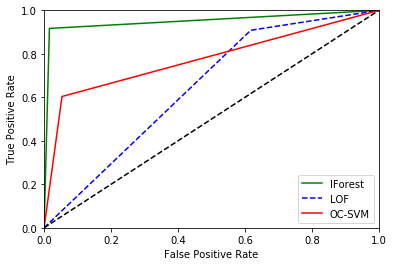

In [15]:
plt.plot(fpr_IF_Shuttle, tpr_IF_Shuttle, "g-", label="IForest") 
plt.plot(fpr_LOF_Shuttle, tpr_LOF_Shuttle, "b--", label="LOF") 
plt.plot(fpr_OCSVM_Shuttle, tpr_OCSVM_Shuttle, "r-", label="OC-SVM") 
plt.plot([0, 1], [0, 1], 'k--') 
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
    
plt.show()

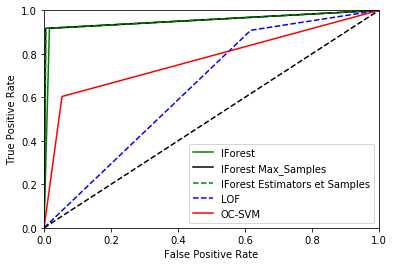

In [16]:
plt.plot(fpr_IF_Shuttle, tpr_IF_Shuttle, "g-", label="IForest") 
plt.plot(fpr_IF_Shuttle_max_samples, tpr_IF_Shuttle_max_samples, "k-", label="IForest Max_Samples") 
plt.plot(fpr_IF_Shuttle_estimators_samples, tpr_IF_Shuttle_estimators_samples, "g--", label="IForest Estimators et Samples") 
plt.plot(fpr_LOF_Shuttle, tpr_LOF_Shuttle, "b--", label="LOF") 
plt.plot(fpr_OCSVM_Shuttle, tpr_OCSVM_Shuttle, "r-", label="OC-SVM") 
plt.plot([0, 1], [0, 1], 'k--') 
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
    
plt.show()

### Interprétation de la courbe ROC
La courbe ROC mesurant le taux de faux positif par rapport au taux de vrai positif, plus la courbe s'éloigne de celle oblique en noir, mieux c'est.
Ainsi, on peut dire que pour Shuttle, IForest est la meilleure méthode de détection d'anomalies suivi par OC-SVM. Le classement de LOF pourrait s'expliquer par le fait que les anomalies qui y sont présentes sont des anomalies global alors que LOF est doué pour les anomalies locales. POur vérifier ça peut être qu'on peut utiliser une méthode de clustering comme K-means pour voir comment les anomalies seront classées par cette méthode.

## Conclusion Shuttle
Pour un jeu de données statique de faible dimension, Isolation forest a tendance à mieux performer et semble être plus rapide que OC-SVM et LOF. OC-SVM détecte beaucoup d'anomalies avec un fort taux de fausses alertes et un temps d'exécution plus grand que LOF. Par contre, LOF détecte moins d'anomalies avec un faible taux de fausses alertes.
Notons que la performance des méthodes dépends non seulement du jeu de données considéré mais aussi des valeurs des hypermaramètres. Pour LOF et IsolationForest, le temps d'exécution semble être en correlation positive avec respectivement le nombre de voisins et nombre de d'estimateurs. Par contre, le temps d'exécution serait en correlation négative avec nu.